In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import SimpleImputer, IterativeImputer

import random

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from listes import *

In [2]:
from mydataviz import *

# Initialisation
## Chargement du dataset

In [3]:
# Chargement du dataset complet (317661, 28)
data = pd.read_csv('./data/data_clean.csv', low_memory=False)

In [4]:
# Création d'un extrait du dataset pour charger et expérimenter plus rapidement
#data_petit = data.iloc[np.random.randint(0, len(data), 50000)]
#data_petit.to_csv("./data/data_clean_petit.csv")

In [5]:
# Chargement du dataset version réduite (50000 valeurs pour les tests)
#data = pd.read_csv("./data/data_clean_petit.csv", low_memory=False)

## Mise en forme initiale

In [6]:
# Suppression de valeurs abérantes qui nuisent aux graphiques
data.loc[data['carbohydrates_100g']<0] = 0
data.loc[data['fat_100g']<0] = 0

In [7]:
# Suppression des restes de colonnes d'index
for c in ['Unnamed: 0.1', 'Unnamed: 0']:
    if c in data.columns:
        data = data.drop(c, axis=1)

## Création de quelques variables utiles

In [8]:
# Création de la liste des colonnes numeriques
listeColFloat = data.select_dtypes(exclude='object').columns.tolist()
if 'code' in listeColFloat : listeColFloat.remove('code')

In [9]:
# Dictionnaire de traduction des noms de colonnes
nomColonnes = {'fat_100g':'Lipides', 'saturated-fat_100g':'Graisses saturées', 'energy_100g':'Energie',
              'carbohydrates_100g':'Glucides', 'sugars_100g':'Sucres', 'proteins_100g':'Protéines',
              'nutrition-score-fr_100g':'Nutriscore', 'omega-3-fat_100g':'Omega3', 'fiber_100g':'Fibres',
              'salt_100g':'Sel', 'sodium_100g':'Sodium', 'fruits-vegetables-nuts_100g':'Fruits, legumes et noix',
              'additives_n':"Nombre d'additifs", 'ingredients_from_palm_oil_n':"Nombre d'ingrédients palmiques",
              'ingredients_that_may_be_from_palm_oil_n':"Nombre d'ingrédients possiblement palmiques",
              'nutrition_grade_fr':'Classement Nutriscore', 'categories':'Catégorie',
              'ingredients_n':"Nombre d'ingrédients", 'additives_score':"Score des additifs", 'code':'Code barre',
              'product_name':'Nom du produit', 'image_url':'URL de l\'image', 'ingredients_text':"Ingrédients",
              'additives':"Liste des ingrédients", 'additives_tags':"Liste des additifs",
              'ingredients_from_palm_oil_tags':"Liste des additifs palmiques",
              'ingredients_that_may_be_from_palm_oil_tags':"Liste des additifs possiblement palmiques"}

In [10]:
# Liste de toutes les catégories par ordre d'importance/remplissage décroissant
listeCatRemplissage = data['categories'].value_counts()

# Exploration des données

## Exploration générale

In [11]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (317661, 27) :



Type des colonnes :
|                                            | 0       |
|:-------------------------------------------|:--------|
| code                                       | int64   |
| product_name                               | object  |
| image_url                                  | object  |
| categories                                 | object  |
| ingredients_text                           | object  |
| additives_n                                | float64 |
| additives                                  | object  |
| additives_tags                             | object  |
| ingredients_from_palm_oil_n                | float64 |
| ingredients_from_palm_oil_tags             | object  |
| ingredients_that_may_be_from_palm_oil_n    | float64 |
| ingredients_that_may_be_from_palm_oil_tags | object  |
| nutrition_grade_fr                         | object  |
| energy_100g                                | float64 |
| fat_100g                   

## Analyse des valeurs nulls

<AxesSubplot: >

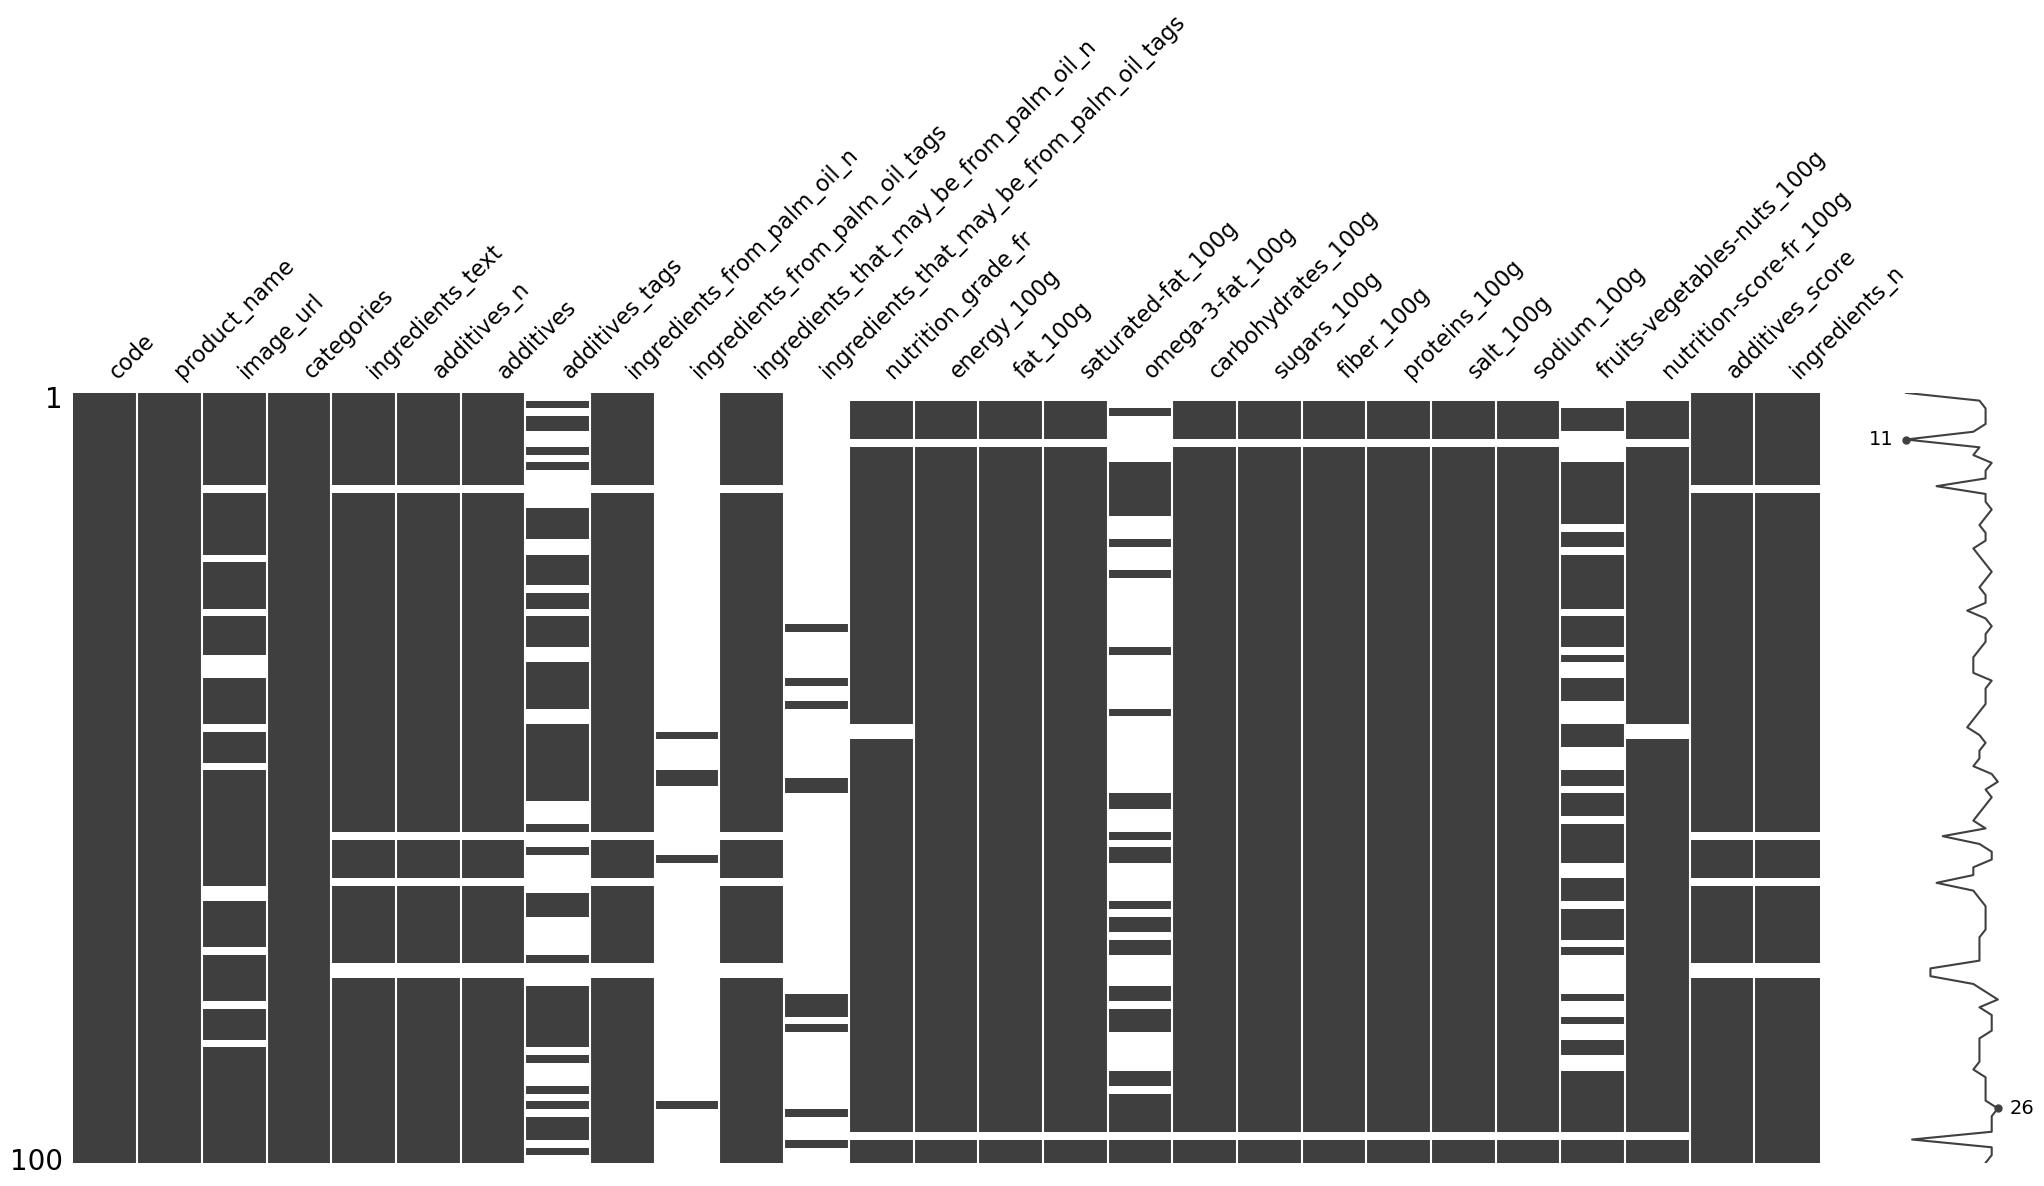

In [12]:
msno.matrix(data[:100])

<AxesSubplot: >

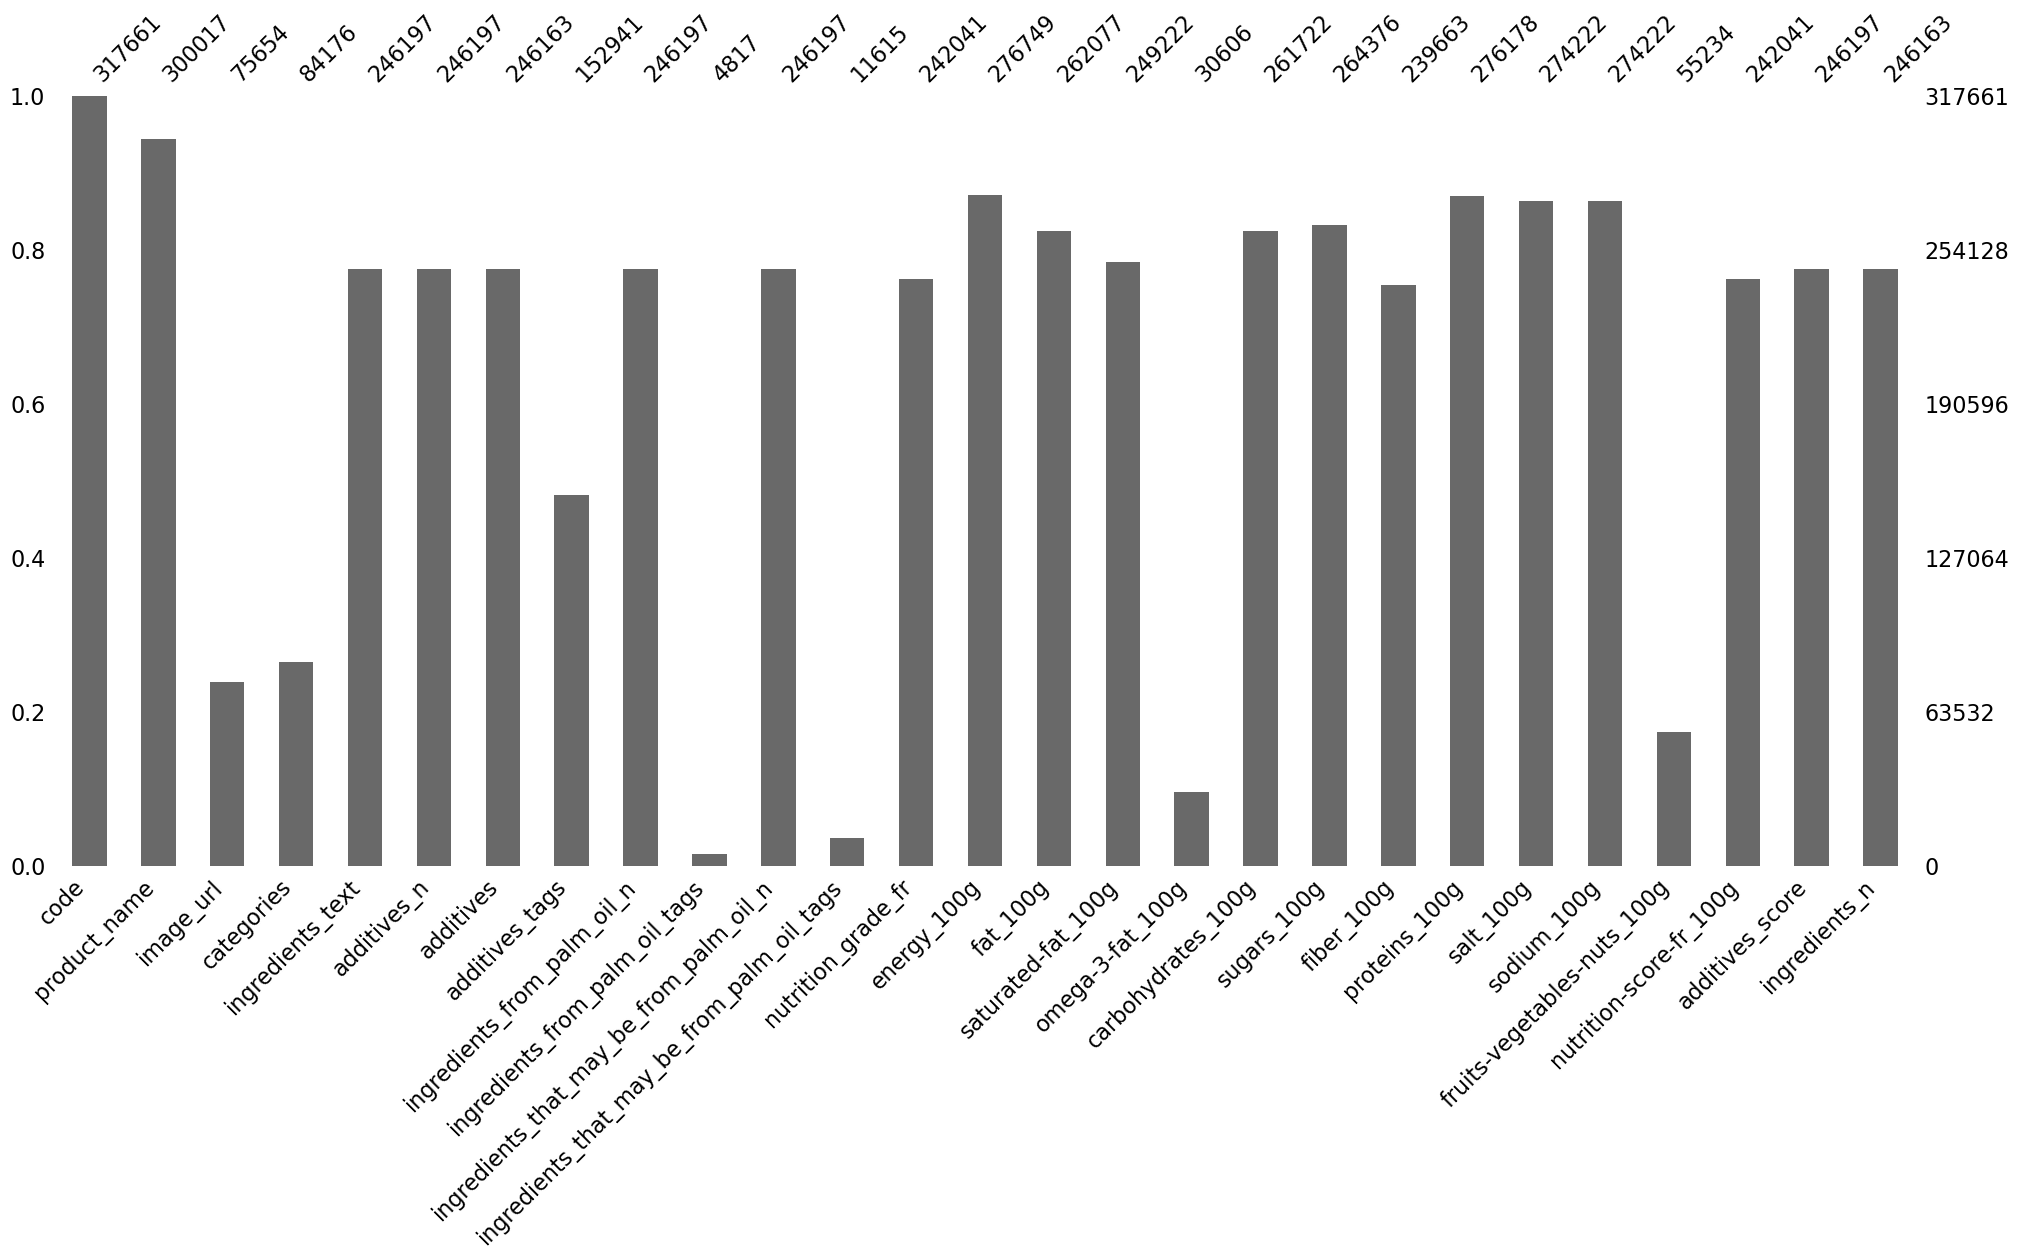

In [13]:
msno.bar(data)

<AxesSubplot: >

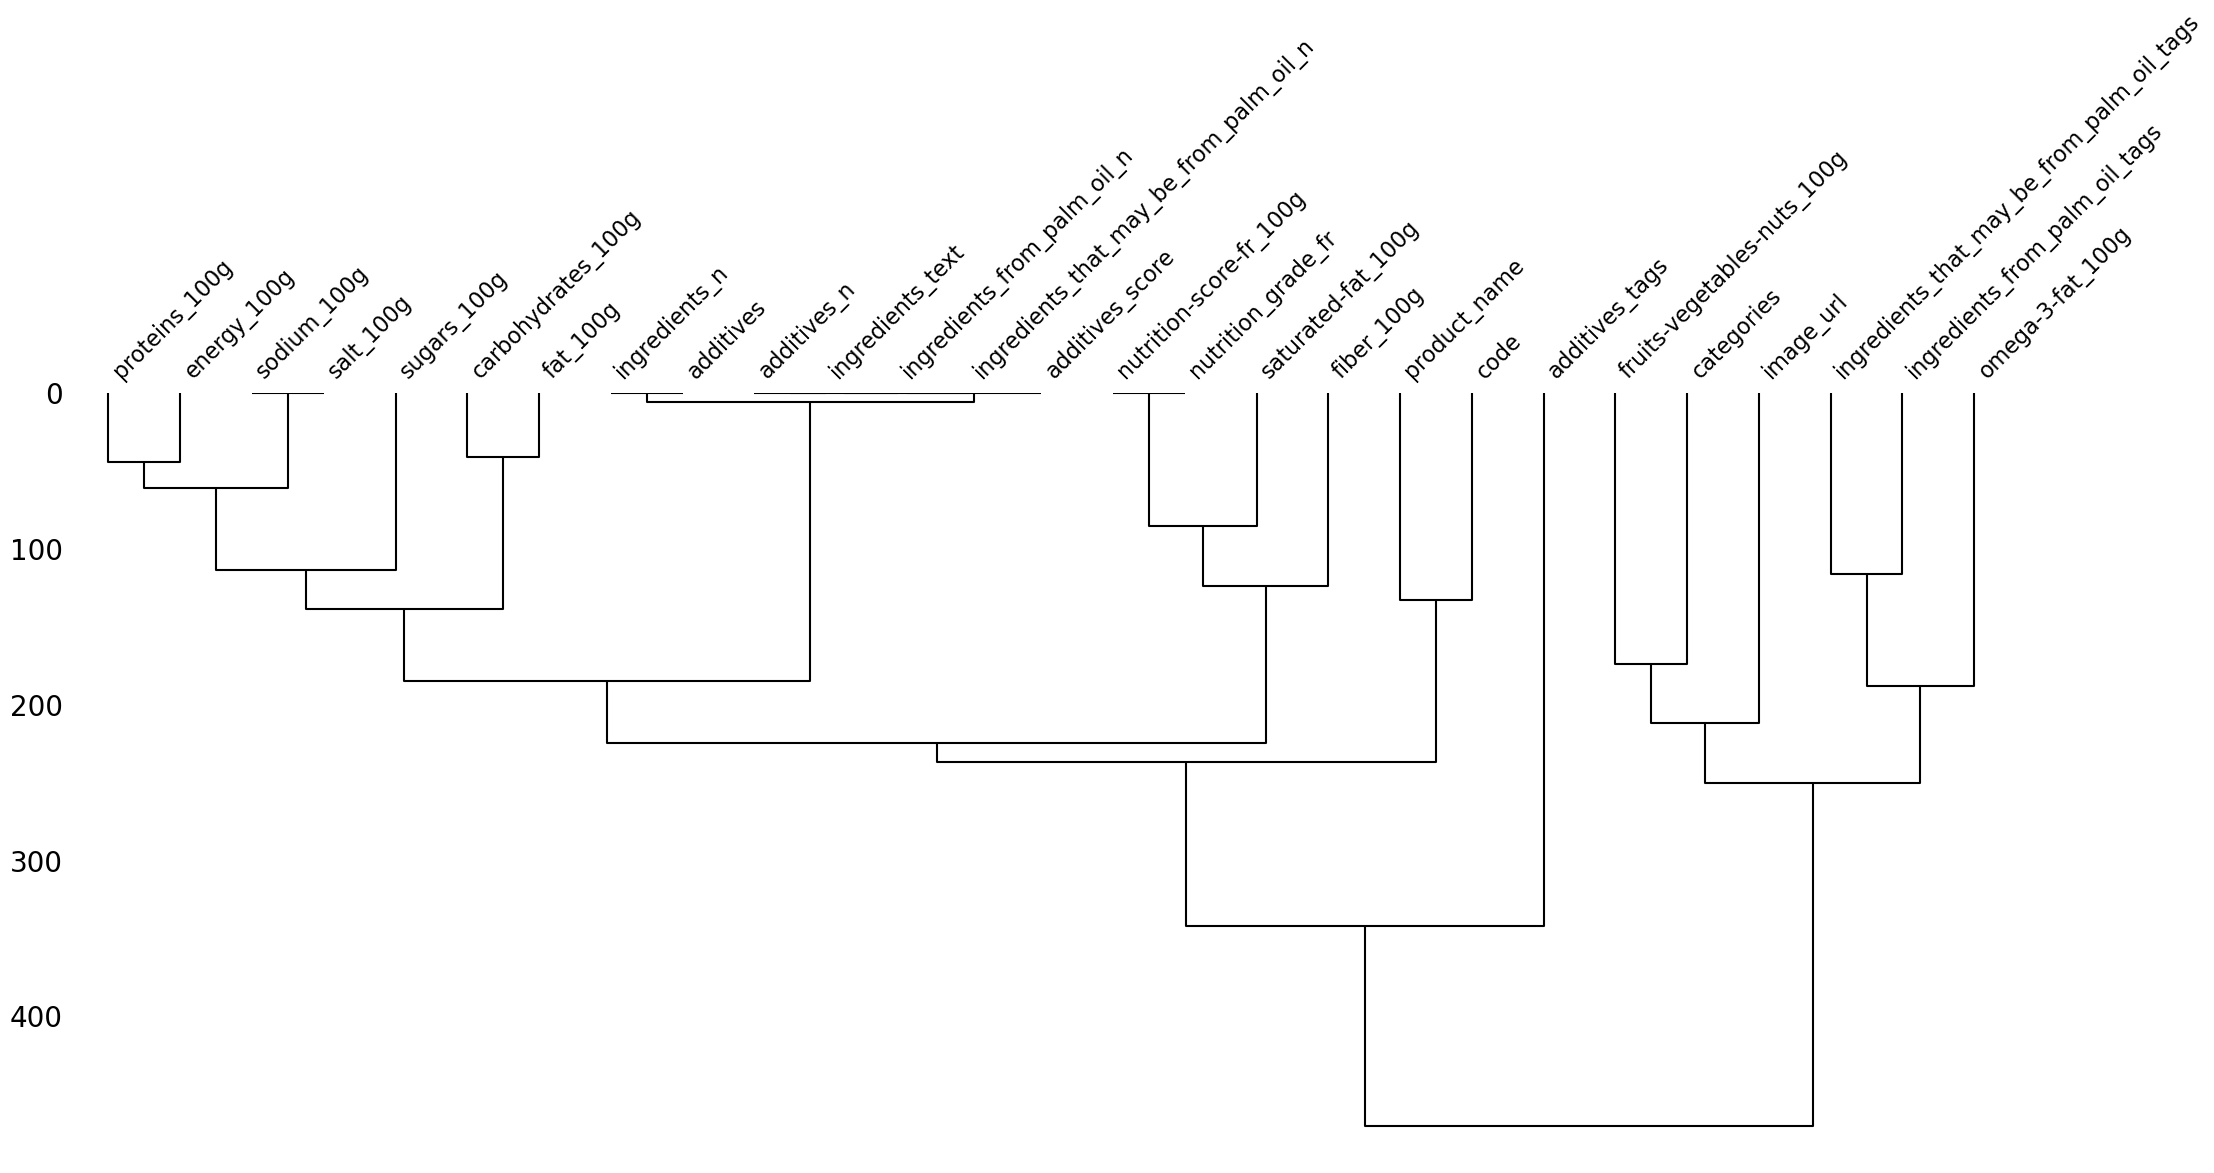

In [14]:
msno.dendrogram(data)

<AxesSubplot: >

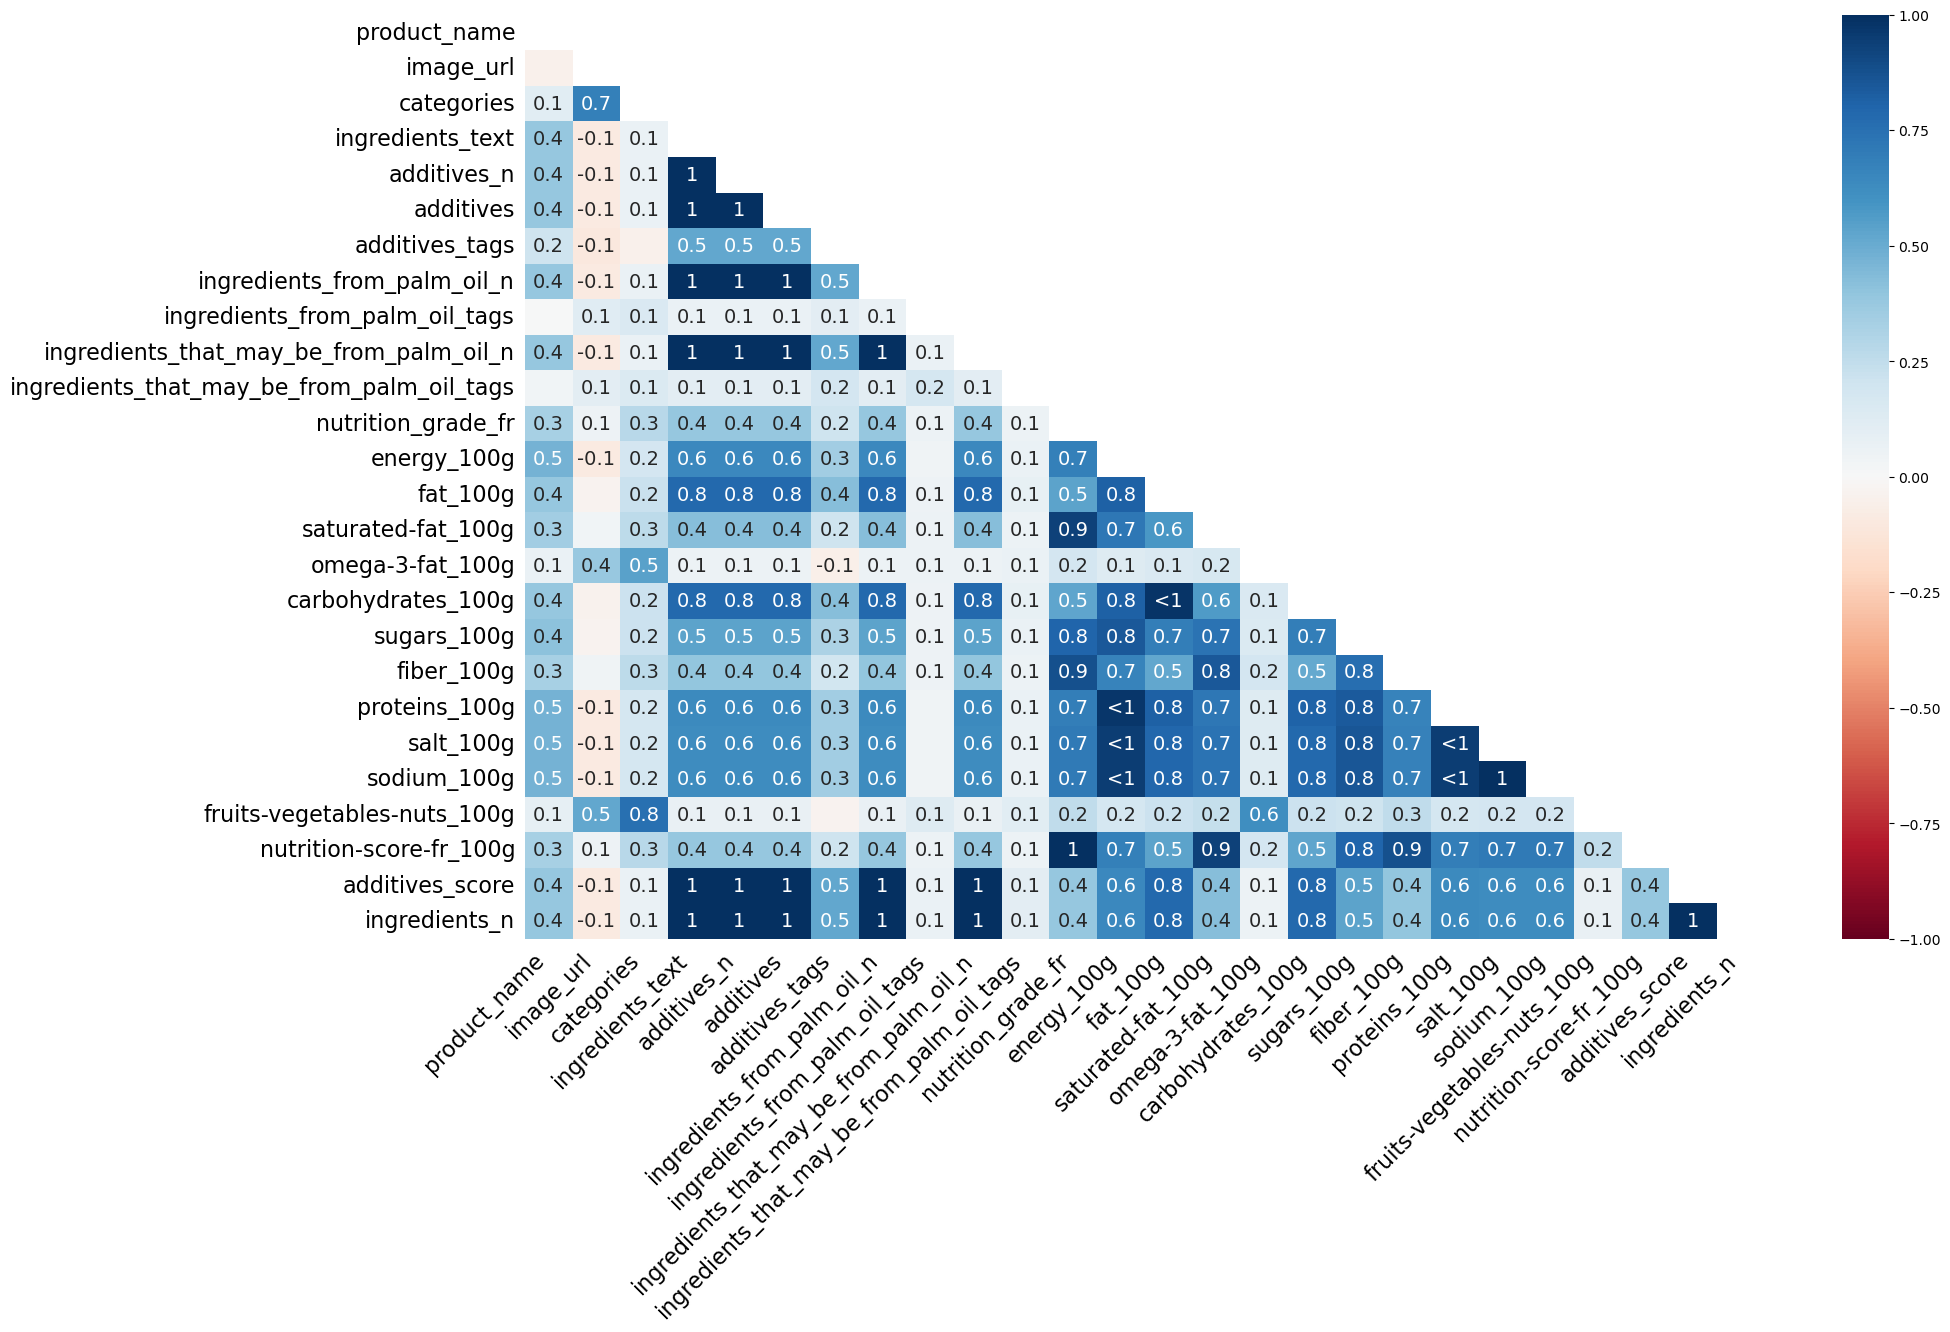

In [15]:
msno.heatmap(data)

## Analyse univarié

### Variables textuelles observées avec des nuages de mots

In [16]:
# Concatenation de tous les noms de produit pour faire une unique variable texte
txt = ' '.join(data['product_name'].astype(str).fillna(''))

In [17]:
tmp = DataSet.make_dataset(txt, 'txt')

In [18]:
wc = tmp.normalise().wordcloud(stopwords=STOPWORDS, width=900, height=600, max_font_size=120, background_color="white")

In [19]:
sns.set(rc={"figure.figsize":(18, 12)})

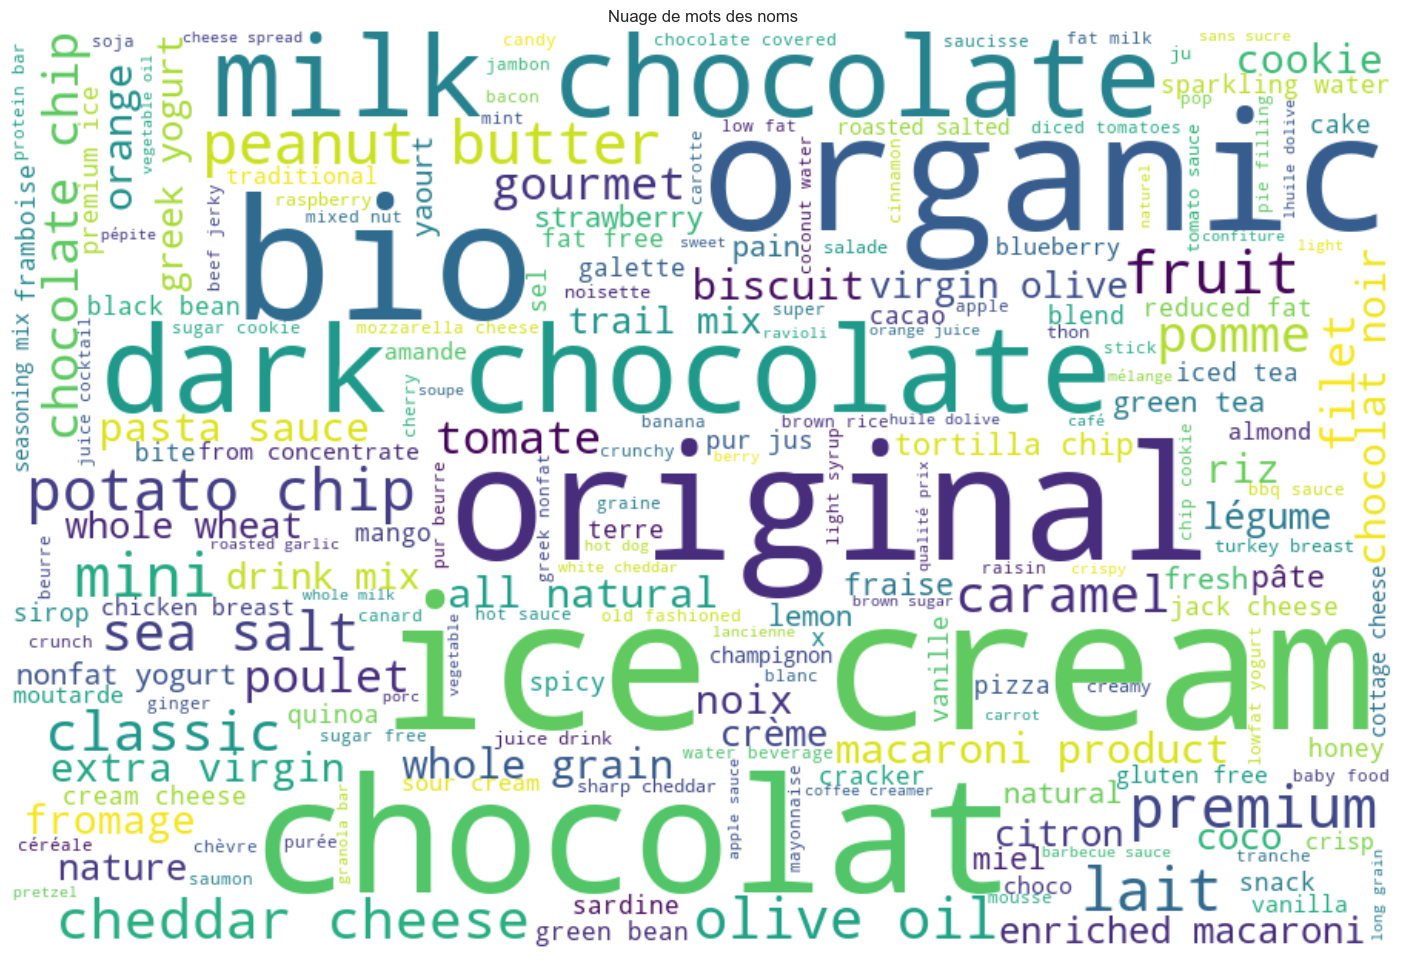

In [20]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des noms")
plt.show()

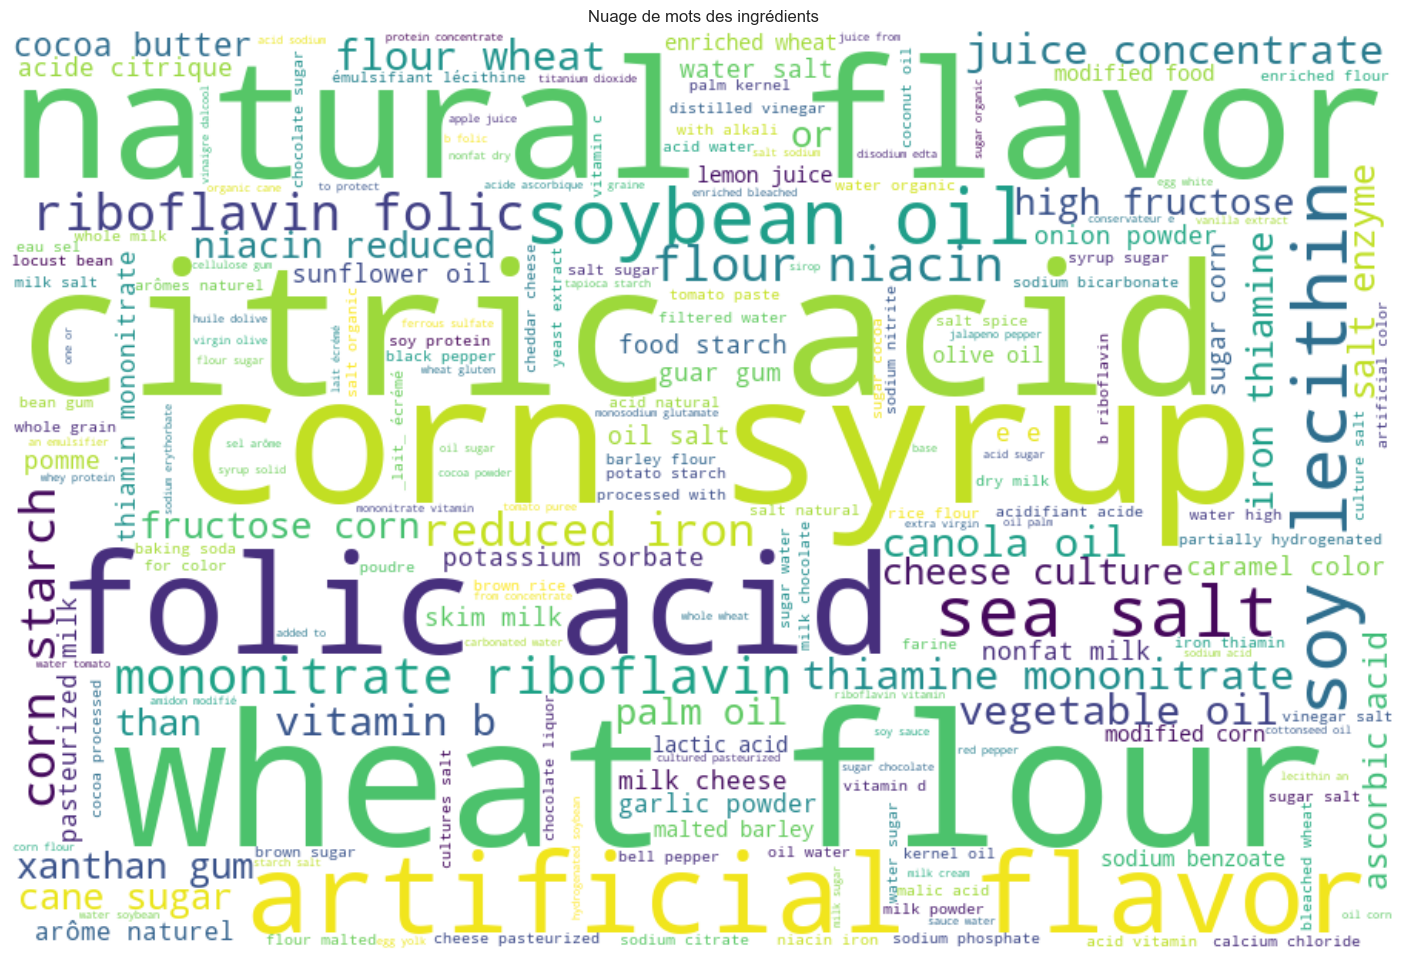

In [21]:
txt = ' '.join(data['ingredients_text'].astype(str).fillna(''))

tmp = DataSet.make_dataset(txt, 'txt')

wc = tmp.normalise().wordcloud(stopwords=STOPWORDS, width=900, height=600, max_font_size=120, background_color="white")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des ingrédients")
plt.show()

### Analyse de variables qualitatives

In [22]:
sns.set(rc={"figure.figsize":(10, 6)})

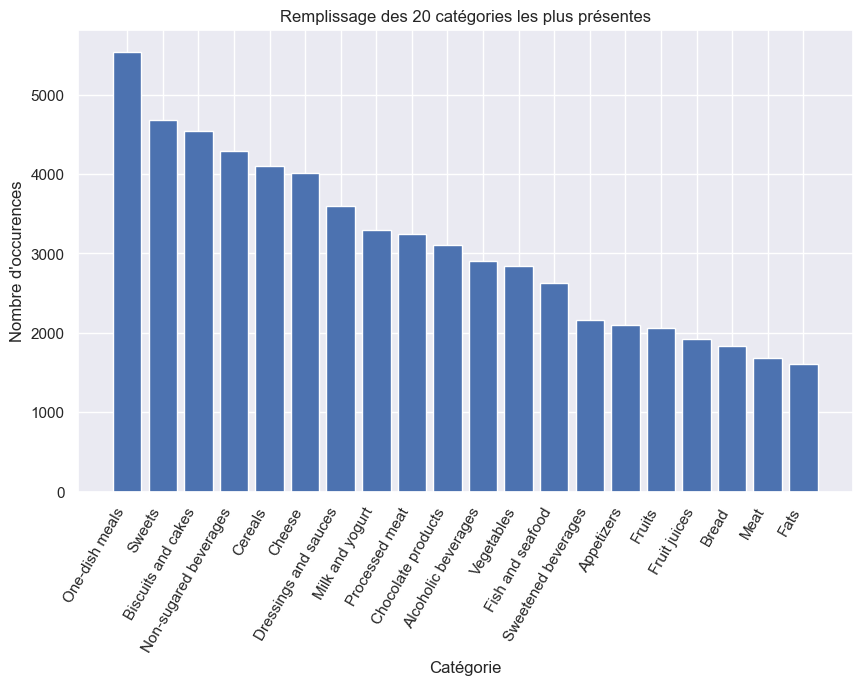

In [23]:
tmp = listeCatRemplissage[:20]

plt.bar(list(tmp.index), tmp.values)

plt.xticks(rotation=60, ha='right')

plt.title("Remplissage des {} catégories les plus présentes".format(len(tmp)))
plt.ylabel("Nombre d'occurences")
plt.xlabel("Catégorie")

plt.show()

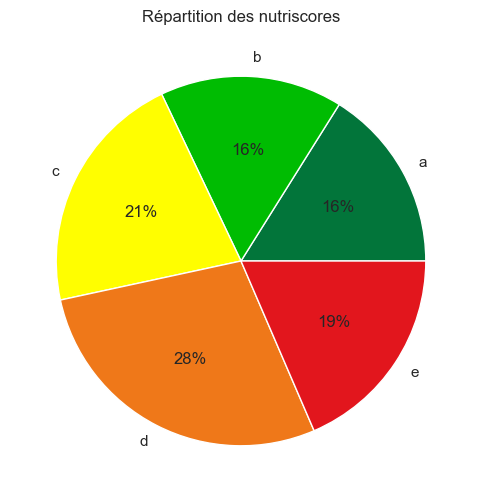

In [24]:
tmp = data['nutrition_grade_fr'].value_counts()

tmp = tmp.reindex(['a', 'b', 'c', 'd', 'e'])


palette_color = sns.color_palette('bright')

plt.pie(tmp.values, labels=tmp.index, colors=['#02753a', '#00bc02', '#fffe00', '#ef7819', '#e2161d'], autopct='%.0f%%')
plt.title("Répartition des nutriscores")
plt.show()

In [25]:
# Création de la liste des 20 additifs les plus présents
tmp = data['additives_tags'].str.split(',', expand = True).stack().str.replace('en:', '')

tmp = tmp.value_counts()[:20]

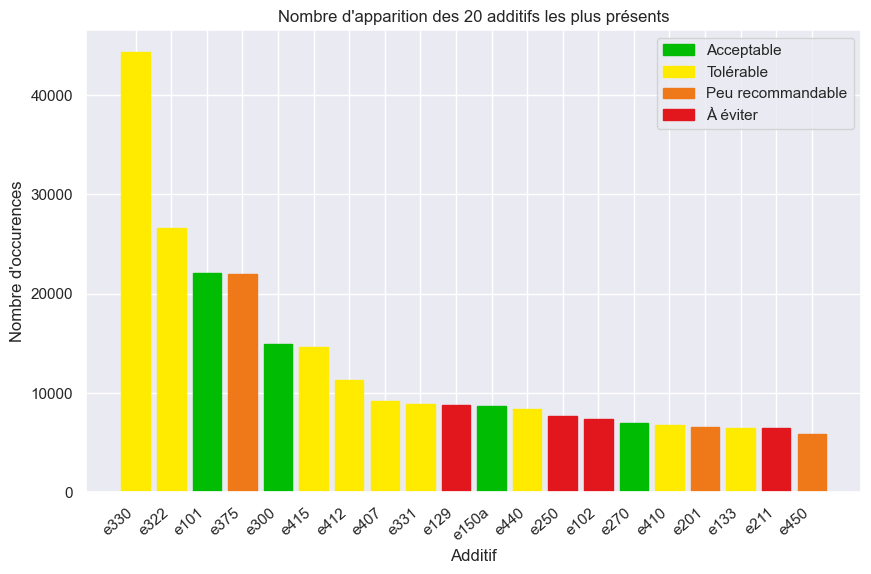

In [26]:
bars = plt.bar(list(tmp.index), tmp.values)

plt.xticks(rotation=40,ha='right')

couleurAdditifs = ['', '#00bc02', '#FFEB00', '#ef7819', '#e2161d']
for i, bar in enumerate(bars):
    a = tmp.index[i]
    if a not in listeAdditifs:
        a = 'e666'
    bar.set_color(couleurAdditifs[listeAdditifs[a]])

plt.title("Nombre d'apparition des {} additifs les plus présents".format(len(tmp)))
plt.ylabel("Nombre d'occurences")
plt.xlabel("Additif")

handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['#00bc02', '#FFEB00', '#ef7819', '#e2161d']]
plt.legend(handles, ['Acceptable', 'Tolérable', 'Peu recommandable', 'À éviter'])

plt.show()

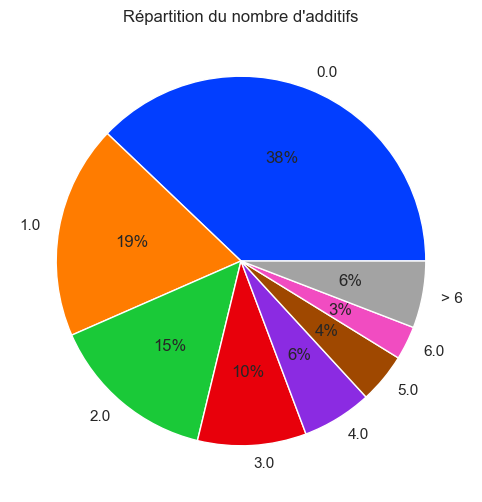

In [27]:
limit = 6

tmp = data['additives_n'].value_counts()

s = sum(tmp[limit+1:])
tmp = tmp[:limit]
tmp['> '+str(limit)] = s

palette_color = sns.color_palette('bright')

plt.pie(tmp.values, labels=tmp.index, colors=palette_color, autopct='%.0f%%')
plt.title("Répartition du nombre d'additifs")
plt.show()

### Analyse de variables quantitatives

In [28]:
sns.set(rc={"figure.figsize":(10, 4)})

In [29]:
cat = 'energy_100g'

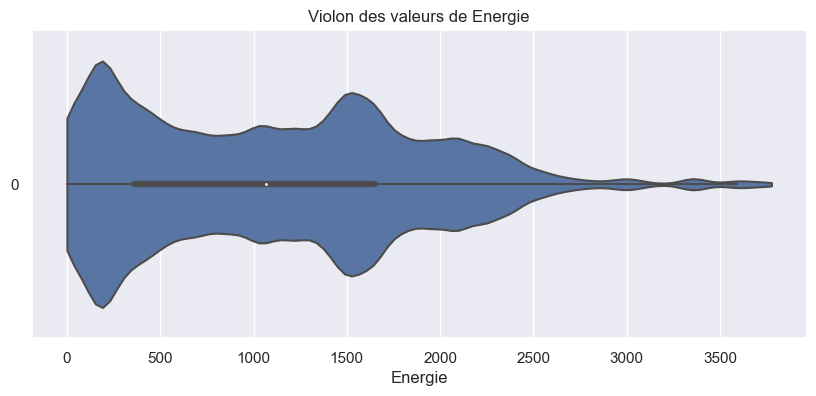

In [30]:
ax = sns.violinplot(data=data[cat], orient='h', scale='width', cut=0)
ax.set(xlabel =nomColonnes[cat], ylabel = '', title ='Violon des valeurs de ' + nomColonnes[cat])
plt.show()

In [31]:
data.loc[(data['fruits-vegetables-nuts_100g'] <55) & (data['fruits-vegetables-nuts_100g'] > 45), ['categories']].value_counts()[:20]

categories            
Fruit juices              1701
Sweets                    1236
Ice cream                  695
Chocolate products         590
Fruit nectars              274
en:plant-based-spreads     230
Sweetened beverages        199
One-dish meals             199
Non-sugared beverages      153
en:spreads                 122
Fruits                     120
Dairy desserts             108
en:sugary-snacks            55
Fats                        40
Soups                       28
en:breakfasts               22
en:baby-foods               16
Cereals                     13
Dried fruits                12
Nuts                        11
dtype: int64

In [32]:
data.loc[(data['fat_100g'] > 35) & (data['categories'] == 'Vegetables')]

code                                       product_name  \
2736    9003740076121                         Kürbiskerne aus Österreich   
4436    8480000800121  Aceitunas negras enteras &quot;Hacendado&quot;...   
27196   8436022470682                                        Tomate seco   
27198   8410972100684                              Tomate seco en aceite   
27199   8410972122044                              Tomate seco en aceite   
58389   3596710427406         Tomates mi-séchées aux herbes de Provence    
60253        42271017                                Getrocknete Tomaten   
69761   8410131035932                           Crispy Poivrons Original   
118290  1302371760002                                         Rostad Lök   
295891  4012200032947                                      Oignons Frits   
299115  4388844055575                                       Röstzwiebeln   

                                                image_url  categories  \
2736    http://fr.openfoodfacts.org/images/products/90...  Vegetables   
4436    http://fr.openfoodfacts.org/images/products/84...  Vegetables   
27196   http://fr.openfoodfacts.org/images/products/84...  Vegetables   
27198   http://fr.openfoodfacts.org/images/products/84...  Vegetables   
27199   http://fr.openfoodfacts.org/images/products/84...  Vegetables   
58389                                                 NaN  Vegetables   
60253                                                 NaN  Vegetables   
69761                                                 NaN  Vegetables   
118290  http://fr.openfoodfacts.org/images/products/13...  Vegetables   
295891  http://fr.openfoodfacts.org/images/products/40...  Vegetables   
299115  http://fr.openfoodfacts.org/images/products/43...  Vegetables   

                                         ingredients_text  additives_n  \
2736                                                  NaN          NaN   
4436        Aceitunas al natural de la variedad empeltre.          0.0   
27196                                 Tomate seco y sal.           0.0   
27198   Tomate seco, aceite 32% (aceite de girasol, ac...          2.0   
27199   Tomate seco, aceite 30% (aceite de girasol, ac...          2.0   
58389   Tomates semi-séchées 60% (tomates 58,8%, sel),...          0.0   
60253   Tomaten getrocknet 53%, Sonnenblumenöl 32%, na...          0.0   
69761                                                 NaN          NaN   
118290     Oignons, huile de palme, farine de _blé_, sel.          0.0   
295891  Oignons (76 %), huile végétale, farine de blé,...          0.0   
299115        Zwiebeln, pflanzliches Öl, Weizenmehl, Salz          0.0   

                                                additives   additives_tags  \
2736                                                  NaN              NaN   
4436     [ aceitunas-al-natural-de-la-variedad-empeltr...              NaN   
27196     [ tomate-seco-y-sal -> es:tomate-seco-y-sal  ]               NaN   
27198    [ tomate-seco -> es:tomate-seco  ]  [ aceite-...  en:e300,en:e330   
27199    [ tomate-seco -> es:tomate-seco  ]  [ aceite-...  en:e300,en:e330   
58389    [ tomates-semi-sechees-60 -> fr:tomates-semi-...              NaN   
60253    [ tomaten-getrocknet-53 -> de:tomaten-getrock...              NaN   
69761                                                 NaN              NaN   
118290   [ oignons -> fr:oignons  ]  [ huile-de-palme ...              NaN   
295891   [ oignons -> fr:oignons  ]  [ 76 -> fr:76  ] ...              NaN   
299115   [ zwiebeln -> de:zwiebeln  ]  [ pflanzliches-...              NaN   

        ingredients_from_palm_oil_n ingredients_from_palm_oil_tags  ...  \
2736                            NaN                            NaN  ...   
4436                            0.0                            NaN  ...   
27196                           0.0                            NaN  ...   
27198                           0.0                            NaN  ...   
27199                     

In [33]:
sns.set(rc={"figure.figsize":(10, 20)})

In [34]:
# Liste des variables à analyser (energy n'est pas dedans pour rendre le graphique plus beau)
df = data[['fat_100g', 'saturated-fat_100g', 'omega-3-fat_100g',
'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 
'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']]

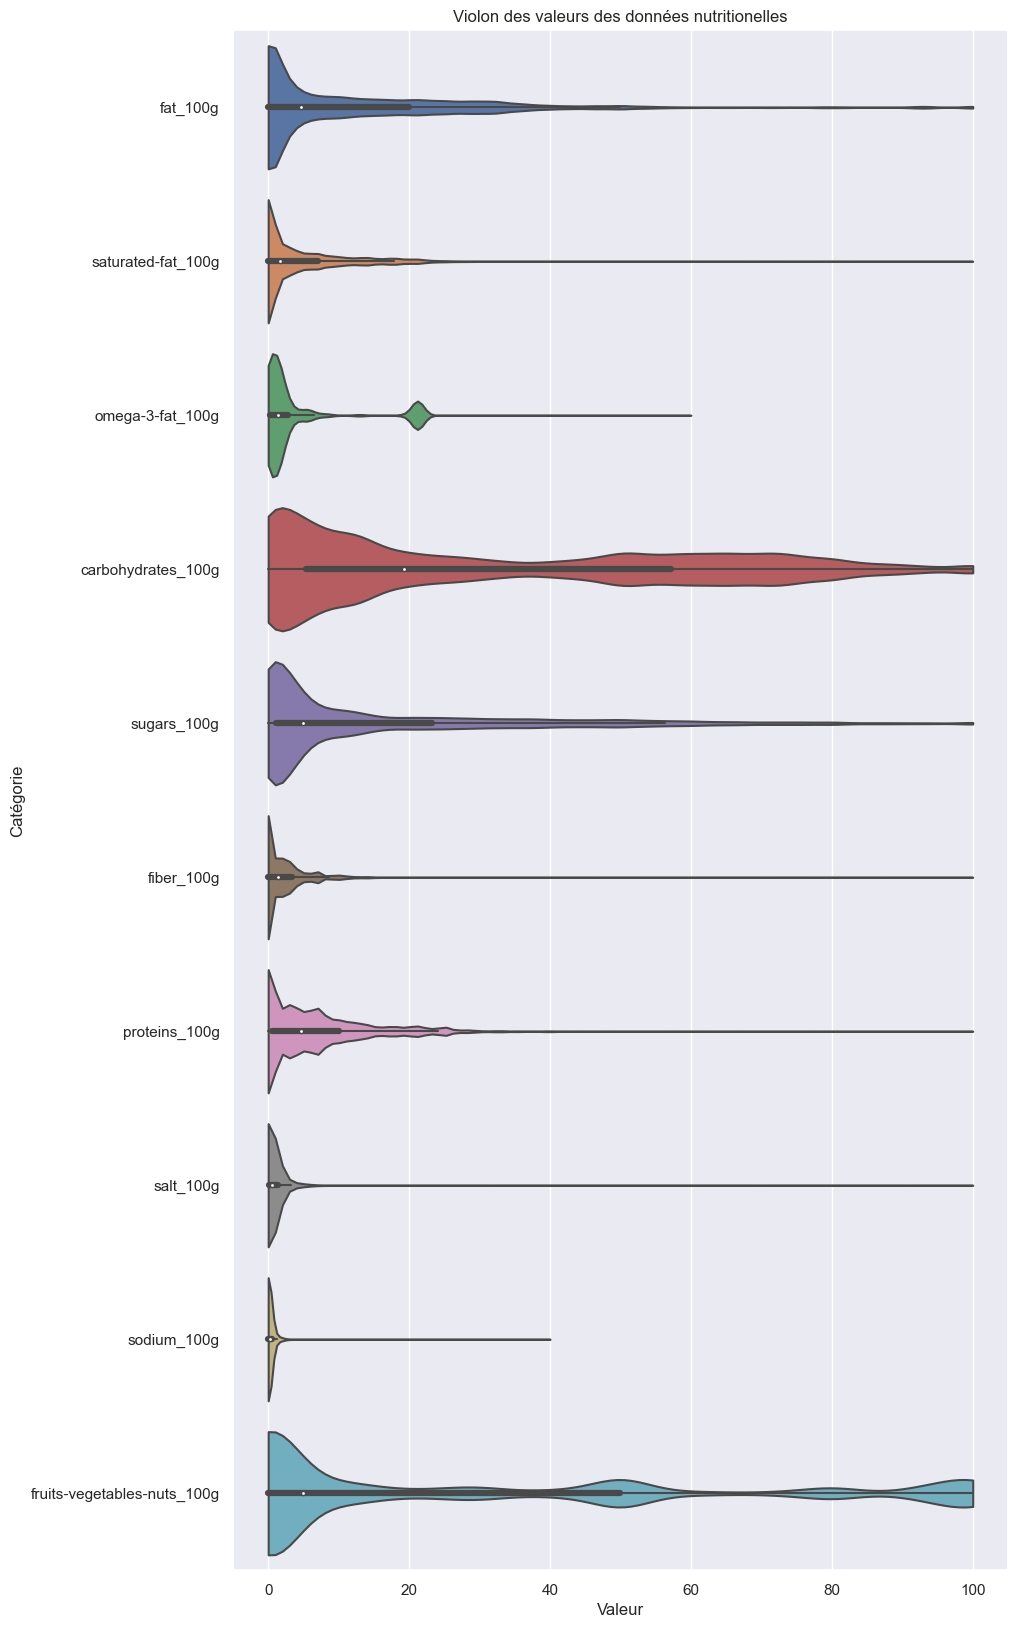

In [35]:
ax = sns.violinplot(data=df, orient='h', scale='width', cut=0)
ax.set(xlabel ="Valeur", ylabel = "Catégorie", title ='Violon des valeurs des données nutritionelles')
plt.show()

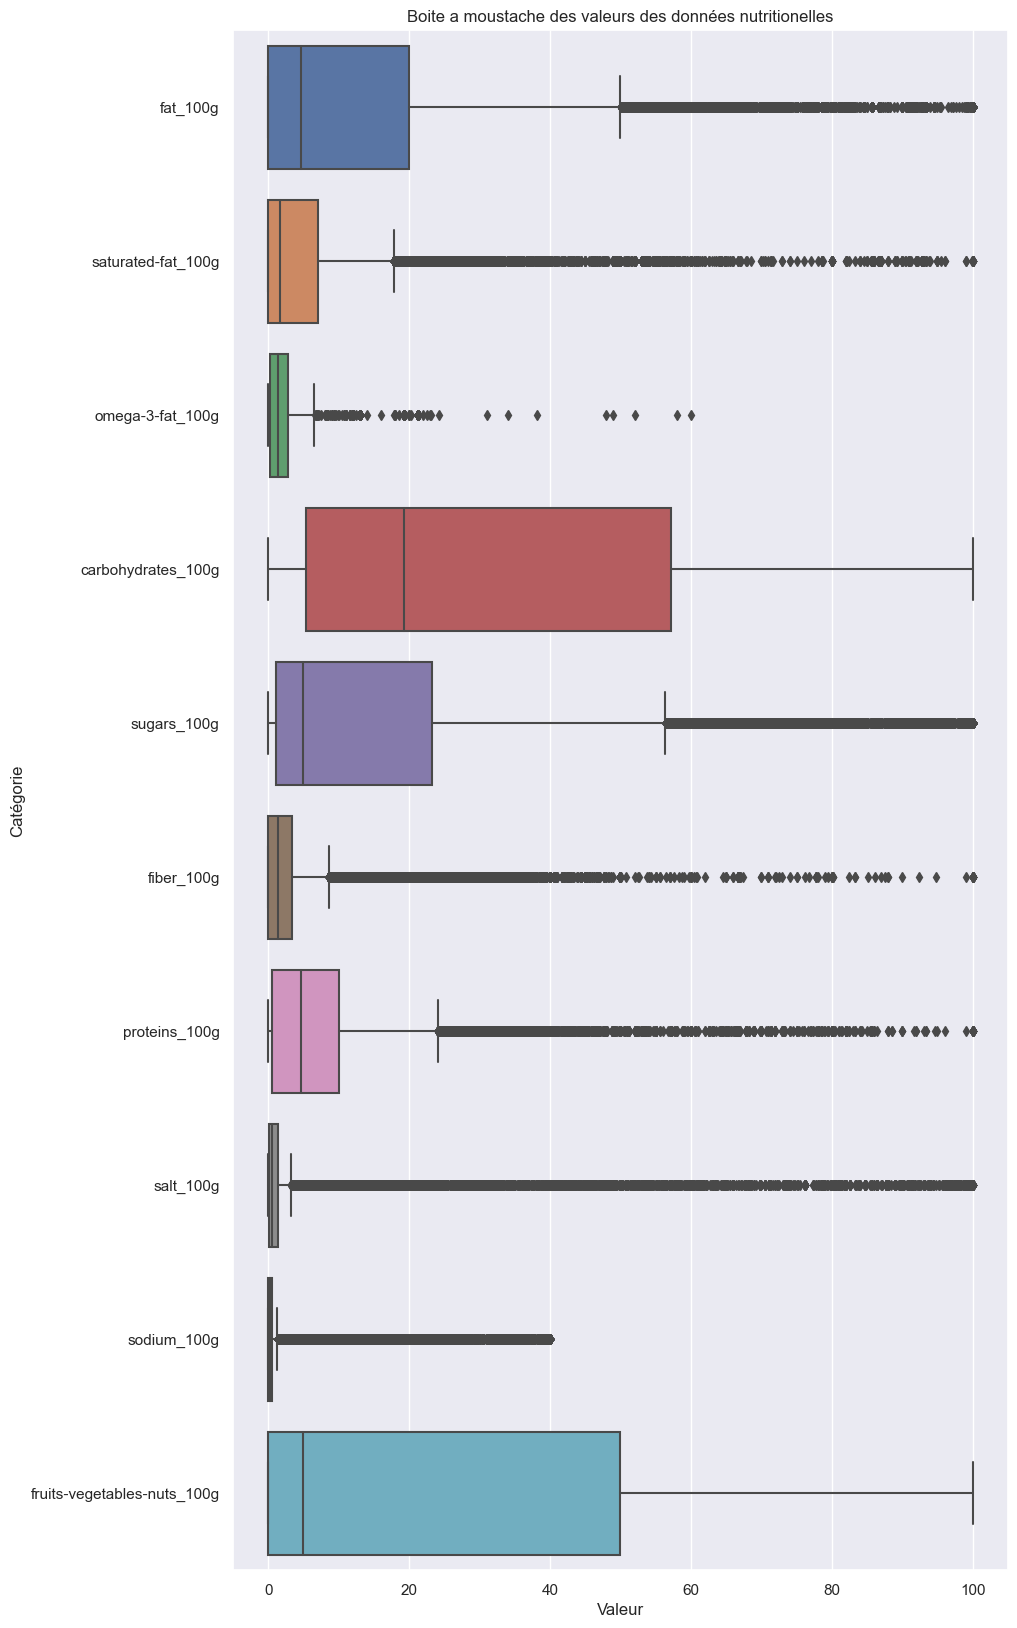

In [36]:
ax = sns.boxplot(data=df, orient='h')
ax.set(xlabel ="Valeur", ylabel = "Catégorie", title ='Boite a moustache des valeurs des données nutritionelles')
plt.show()

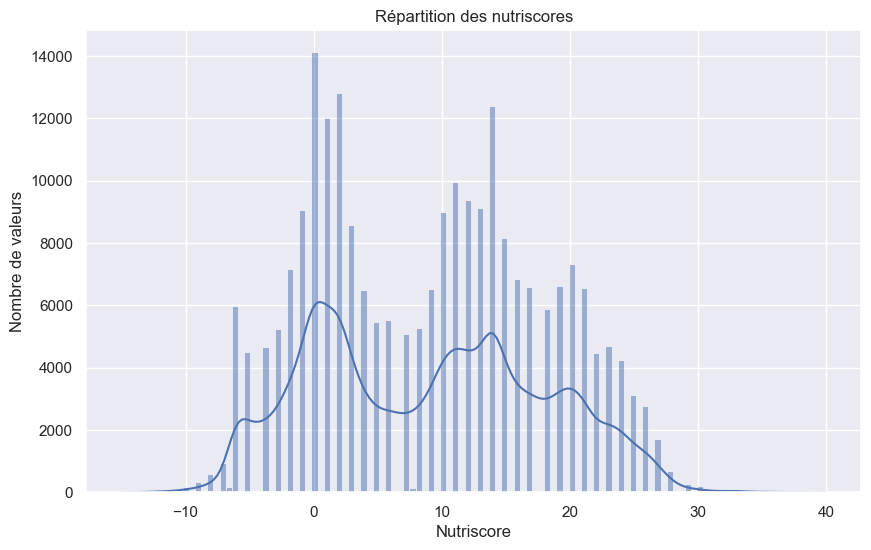

In [37]:
sns.set(rc={"figure.figsize":(10, 6)})
ax = sns.histplot(data=data['nutrition-score-fr_100g'], kde=True)
ax.set(xlabel ="Nutriscore", ylabel = "Nombre de valeurs", title ='Répartition des nutriscores')
plt.show()

## Analyses bivariées

### Graphiques interactifs pour les variables quantitatives

In [38]:
%matplotlib inline
sns.set(rc={"figure.figsize":(8, 6)})

In [39]:
@interact
def show_articles_more_than(x=widgets.Dropdown(options=listeColFloat, value='fat_100g'),
                            y=widgets.Dropdown(options=listeColFloat, value='saturated-fat_100g'), 
                            couleur=widgets.Dropdown(options=listeColFloat, value='energy_100g')):
    fig = plt.figure()
    ax = plt.axes()

    ax.scatter(data[x], data[y], c=data[couleur], alpha=0.3)

    ax.set_title('3d Scatter plot geeks for geeks')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()

interactive(children=(Dropdown(description='x', index=4, options=('additives_n', 'ingredients_from_palm_oil_n'…

In [40]:
# Création d'une liste de combinaison de variables interessantes à étudier
listeScatter = pd.DataFrame([['fat_100g', 'saturated-fat_100g', 'energy_100g', None],
                             ['carbohydrates_100g', 'sugars_100g', 'energy_100g', None],
                             ['fat_100g', 'proteins_100g', 'energy_100g', None],
                             ['fat_100g', 'proteins_100g', 'nutrition-score-fr_100g', None],
                             ['proteins_100g', 'carbohydrates_100g', 'nutrition-score-fr_100g', None],
                             ['fat_100g', 'carbohydrates_100g', 'nutrition-score-fr_100g', None],
                             ['salt_100g', 'sodium_100g', '', None],
                             ['additives_score', 'ingredients_n', 'energy_100g', None],
                             ['additives_score', 'additives_n', 'ingredients_n', None],
                             ['nutrition-score-fr_100g', 'energy_100g', '', None]], columns=['x', 'y', 'c', 'title'])

listeScatter['title'] = listeScatter['x'] + ' * ' + listeScatter['y'] + ' - ' + listeScatter['c']

listeInteract = []

for i in listeScatter.index:
    listeInteract += [(listeScatter.loc[i, 'title'], i)]

In [41]:
from matplotlib.colors import LogNorm

In [42]:
@interact
def show_articles_more_than(graphique=widgets.Dropdown(options=listeInteract)):
    x = listeScatter.loc[graphique, 'x']
    y = listeScatter.loc[graphique, 'y']
    c = listeScatter.loc[graphique, 'c']
    
    if c != '':
        cNom = nomColonnes[c]
        c = data[c]
    else:
        cNom = ''
        c = 'b'
    t = listeScatter.loc[graphique, 'title']
    
    fig = plt.figure()
    ax = plt.axes()

    
    if cNom == "Nombre d'ingrédients":
        sc = ax.scatter(data[x], data[y], c=c, alpha=1, norm=LogNorm())
        ax.scatter(data[x], data[y], c=c, alpha=0.2, norm=LogNorm())
    else:
        sc = ax.scatter(data[x], data[y], c=c, alpha=1)
        ax.scatter(data[x], data[y], c=c, alpha=0.2)

    ax.set_title(nomColonnes[x] + ' * ' + nomColonnes[y] + ' (' + cNom + ')')
    ax.set_xlabel(nomColonnes[x])
    ax.set_ylabel(nomColonnes[y])
    
    
    #legend
    if cNom != '':
        cb = fig.colorbar(sc, ax=ax)
        cb.set_label(cNom)
    
    
    plt.show()

interactive(children=(Dropdown(description='graphique', options=(('fat_100g * saturated-fat_100g - energy_100g…

In [43]:
%matplotlib notebook

<IPython.core.display.Javascript object>


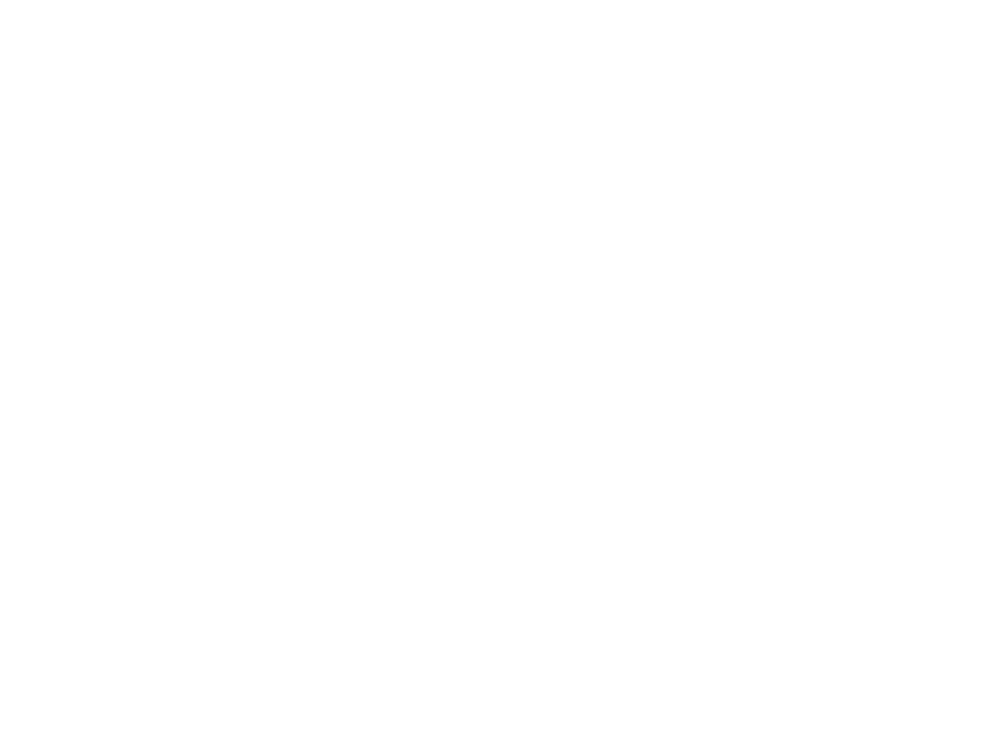

In [44]:
fig = plt.figure()
ax = plt.axes(projection="3d")

#energy_100g
sc = ax.scatter(data['fat_100g'], data['carbohydrates_100g'], data['proteins_100g'], c=data['nutrition-score-fr_100g'], alpha=1, s=0)
ax.scatter(data['fat_100g'], data['carbohydrates_100g'], data['proteins_100g'], c=data['nutrition-score-fr_100g'], alpha=0.1, s=7)

ax.set_title('3d Scatter plot geeks for geeks')
ax.set_xlabel('Lipides')
ax.set_ylabel('Glucides')
ax.set_zlabel('Proteines')

cb = fig.colorbar(sc, ax=ax)
cb.set_label('Nutriscore')

plt.show()

#### Heatmap pour toutes les variables quantitatives

In [45]:
%matplotlib inline

<AxesSubplot: >

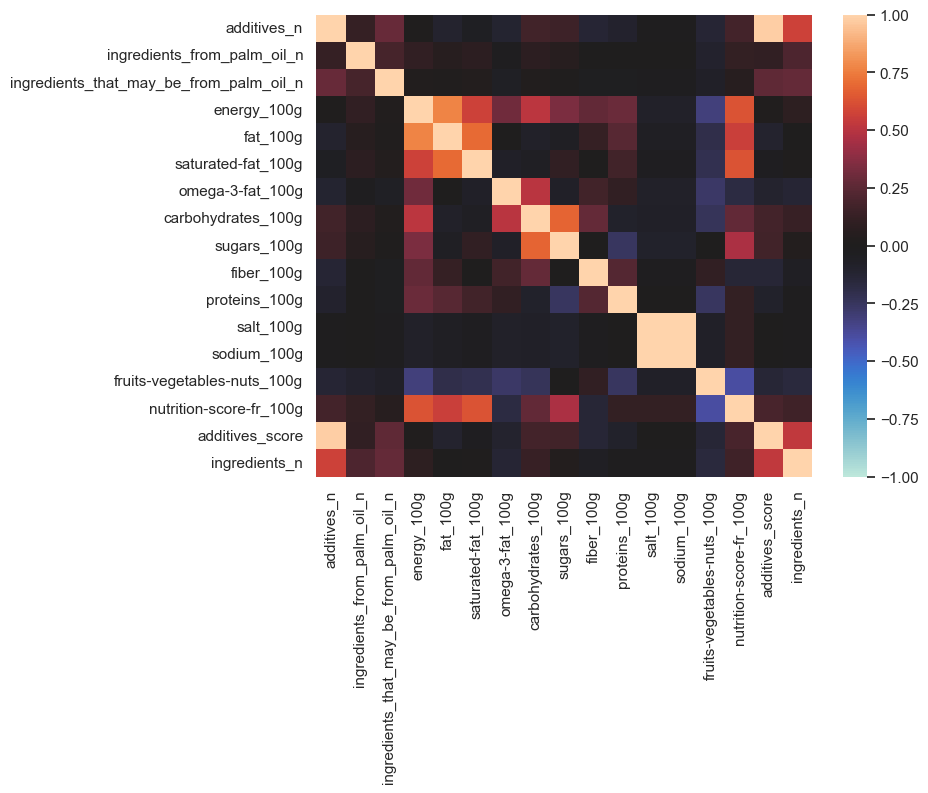

In [46]:
sns.heatmap(data[listeColFloat].corr(), vmin=-1, vmax=1, center=0)

#### Heatmap pour la totalitée des variables
avec donc conversion des variables qualitatives avec le LabelEncoder

In [47]:
listeColNonFloat = [c for c in data.columns if c not in listeColFloat]

In [48]:
dataTmp = data.copy()

In [49]:
label_encoder = LabelEncoder()

In [50]:
for c in [c for c in data.columns if c not in listeColFloat]:
    if c == 'nutrition_grade_fr':
        d ={'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, np.NaN:np.NaN}
        dataTmp[c] = dataTmp[c].apply(lambda x : d[x])
    else:
        dataTmp[c] = label_encoder.fit_transform(dataTmp[c].astype(str))

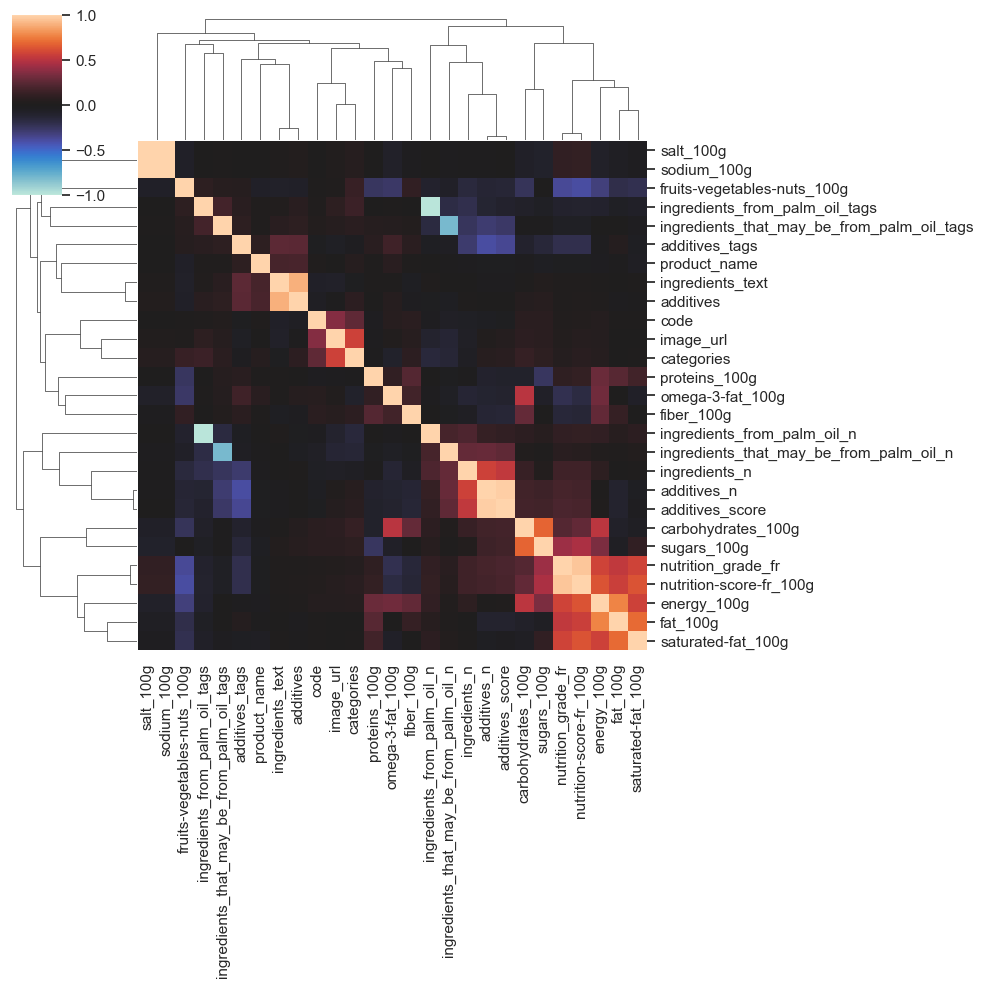

In [51]:
h = sns.clustermap(dataTmp.corr(), vmin=-1, vmax=1, center=0)

#### Extraction du dendrogram

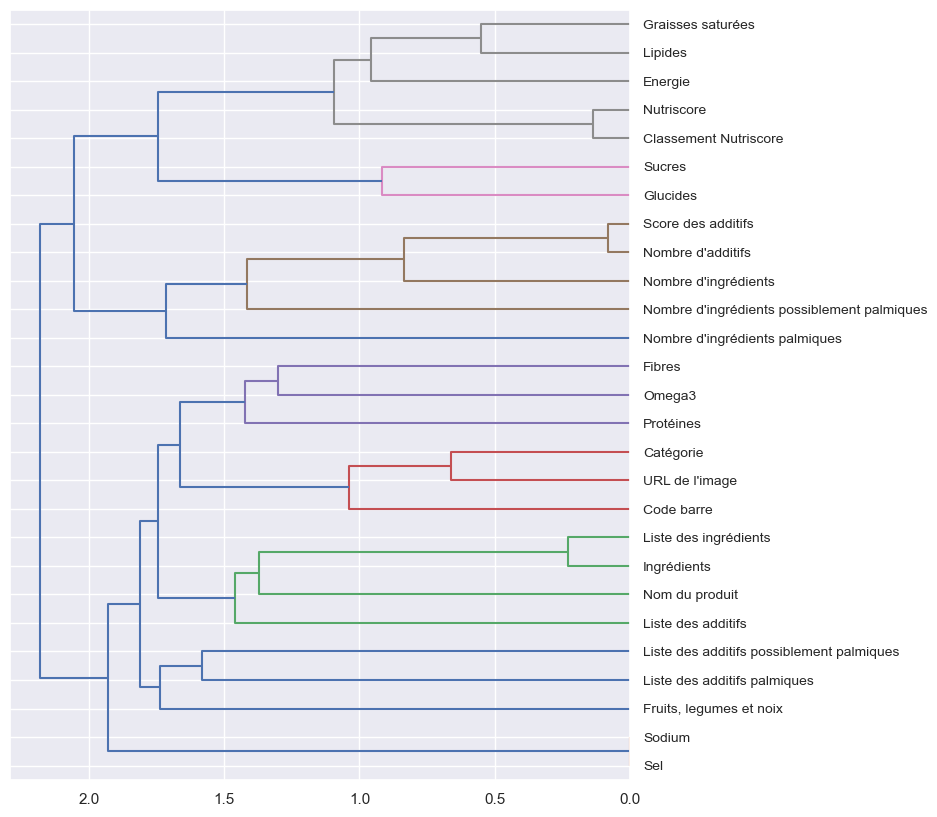

In [52]:
sns.set(rc={"figure.figsize":(8, 10)})
dendrogram(h.dendrogram_col.linkage, labels=[nomColonnes[c] for c in dataTmp.columns], orientation='left');

### Analyse pour une variables quantitative et une autre qualitative

In [53]:
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 12)})

In [54]:
nbVals = 15

In [55]:
# On ne garde que les lignes étant dans l'une des nbVals catégories les plus remplis
dataFrequent = data.loc[data["categories"].isin(listeCatRemplissage[:nbVals].index.to_list())]

In [56]:
@interact
def show_articles_more_than(x=widgets.Dropdown(options=listeColFloat, value='fat_100g')):
    #ax = sns.stripplot(data=dataFrequent, x=x, y="categories", hue="nutrition-score-fr_100g", orient='h', alpha=0.3)
    ax = sns.boxplot(data=dataFrequent, x=x, y="categories", orient='h')
    
    ax.set(xlabel=nomColonnes[x],
           ylabel='Catégorie',
           title='Boxplot des ' + nomColonnes[x] + ' pour les ' + str(nbVals) + ' catégories les plus fréquentes')
        
    listCat = [t.get_text()  for t in ax.get_yticklabels()]
    listTmp = []
    for n in listCat:
        nb = dataFrequent.loc[dataFrequent['categories']==n, x].notna().sum()
        listTmp += [(n, nb)]
    
    ax.set_yticklabels(["{} ({})".format(n, nb) for n, nb in listTmp])

    
    plt.show()

interactive(children=(Dropdown(description='x', index=4, options=('additives_n', 'ingredients_from_palm_oil_n'…

In [57]:
col = ['fat_100g','carbohydrates_100g','proteins_100g']

In [58]:
listCat = ['One-dish meals', 'Fish and seafood', 'Legumes', 'Dairy desserts', 'Cheese']

In [59]:
fig = go.Figure()


m = 0
for cat in listCat:
    val = data.loc[data['categories']==cat, col].median()
    m = max(m, val.max())
    fig.add_trace(go.Scatterpolar(
          r=val.values,
          theta=col,
          fill='toself',
          name=cat
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, m]
    )),
  showlegend=True
)


fig.show()

### Analyse pour deux variables qualitatives

In [60]:
sns.set(rc={"figure.figsize":(8, 6)})

In [61]:
y = 'additives_n'

In [62]:
tmp = data[[y, 'nutrition_grade_fr']].copy().dropna()

In [63]:
tmp[y] = pd.qcut(tmp[y], 7, duplicates='drop')

In [64]:
tmp['nutrition_grade_fr'] = pd.Categorical(tmp['nutrition_grade_fr'], ['a', 'b', 'c', 'd', 'e', 'f'])

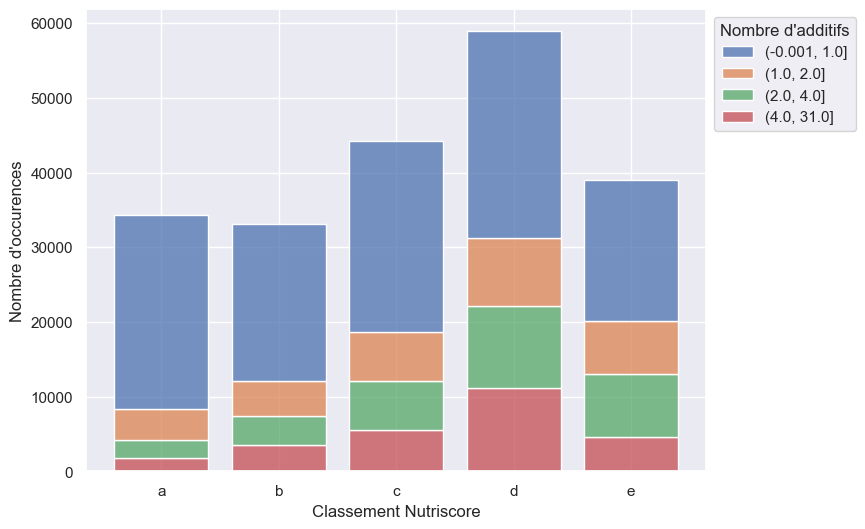

In [65]:
ax = sns.histplot(tmp, x='nutrition_grade_fr', hue=y,
             multiple='stack', shrink=0.8)

ax.set_xlabel(nomColonnes['nutrition_grade_fr'])
ax.set_ylabel("Nombre d'occurences")
    
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
legend.set_title(nomColonnes[y])

In [66]:
sns.set(rc={"figure.figsize":(8, 6)})

In [67]:
dataHeatmap = data.loc[data['categories'].isin(listeCatRemplissage[:10].index)]

In [68]:
dataHeatmap = dataHeatmap[['nutrition_grade_fr', 'categories']]

In [69]:
dataHeatmap['val'] = 1

In [70]:
dataHeatmap = dataHeatmap.pivot_table(values='val',index='categories',columns='nutrition_grade_fr',aggfunc=np.sum)

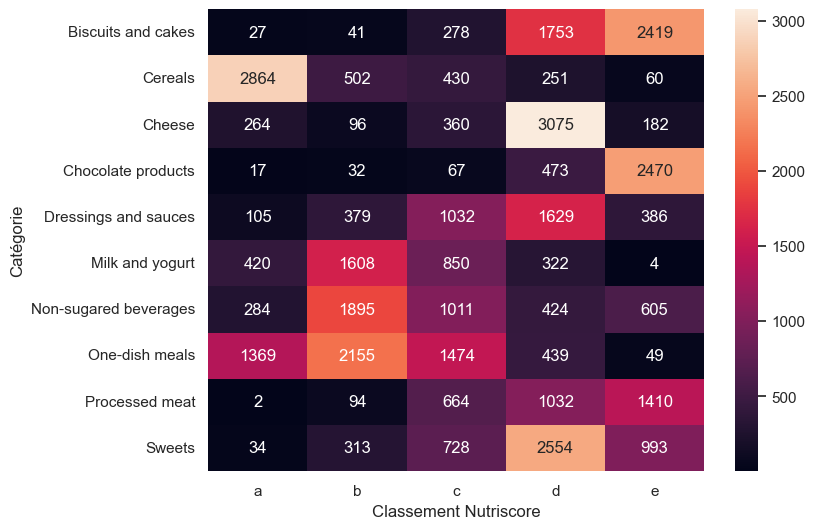

In [71]:
ax = sns.heatmap(dataHeatmap,annot=True, fmt='1.0f')

plt.xticks(rotation=0)
plt.yticks(rotation=0)

ax.set_xlabel(nomColonnes['nutrition_grade_fr'])
ax.set_ylabel(nomColonnes['categories'])

plt.show()

## ACP

In [72]:
sns.set(rc={"figure.figsize":(10, 6)})

In [73]:
scaler = StandardScaler()

In [74]:
listeColNum = listeColFloat.copy()

In [75]:
# Suppression de colonnes trop vides ou inutiles (trop proches d'autres colonnes, rendant donc le graphique moins lisible)
listeColNum.remove('sodium_100g')
#listeColNum.remove('sugars_100g')
listeColNum.remove('omega-3-fat_100g')
#listeColNum.remove('saturated-fat_100g')
listeColNum.remove('additives_n')
listeColNum.remove('ingredients_from_palm_oil_n')
listeColNum.remove('ingredients_that_may_be_from_palm_oil_n')
listeColNum.remove('fruits-vegetables-nuts_100g')

In [76]:
dataPCA = data[listeColNum + ['product_name']].copy()
dataPCA['product_name'] = dataPCA['product_name'].fillna('NaN')

In [77]:
nbTmp = len(dataPCA)
dataPCA = dataPCA.dropna()
print("On a enlevé {:0.2f}% de lignes. Il en reste {}".format(100*(nbTmp - len(dataPCA))/nbTmp, len(dataPCA)))

On a enlevé 36.44% de lignes. Il en reste 201920


In [78]:
dataPCANoms = dataPCA['product_name'].fillna('NaN')
dataPCA = dataPCA.drop('product_name', axis=1)

In [79]:
# dataPCA = SimpleImputer(missing_values=np.nan, strategy='mean').fit(dataPCA).transform(dataPCA)

In [80]:
X_scaled = scaler.fit_transform(dataPCA)

In [81]:
pd.DataFrame(X_scaled).describe().round(2)

0          1          2          3          4          5   \
count  201920.00  201920.00  201920.00  201920.00  201920.00  201920.00   
mean       -0.00      -0.00      -0.00       0.00       0.00      -0.00   
std         1.00       1.00       1.00       1.00       1.00       1.00   
min        -1.53      -0.82      -0.66      -1.15      -0.75      -0.64   
25%        -0.94      -0.78      -0.66      -0.92      -0.69      -0.64   
50%         0.02      -0.40      -0.44      -0.34      -0.50      -0.28   
75%         0.70       0.52       0.30       0.90       0.40       0.23   
max         3.45       5.43      13.29       2.38       4.38      23.41   

              6          7          8          9          10  
count  201920.00  201920.00  201920.00  201920.00  201920.00  
mean        0.00      -0.00      -0.00       0.00      -0.00  
std         1.00       1.00       1.00       1.00       1.00  
min        -0.97      -0.29      -2.65      -0.72      -1.05  
25%        -0.75      -0.27      -0.88      -0.72      -0.70  
50%        -0.27      -0.14       0.01      -0.38      -0.14  
75%         0.38       0.03       0.79       0.31       0.30  
max        11.60      23.23       3.45      11.99      21.81

In [82]:
n_components = 6

In [83]:
pca = PCA(n_components=n_components)

In [84]:
pca.fit(X_scaled)

PCA(n_components=6)

In [85]:
(pca.explained_variance_ratio_*100).round(2)

array([29.83, 18.4 , 13.9 , 11.16,  9.18,  6.04])

In [86]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = listeColNum
pcs.index = [f"F{i}" for i in range(1, n_components+1)]
pcs.columns = [nomColonnes[c] for c in pcs.columns.tolist()]


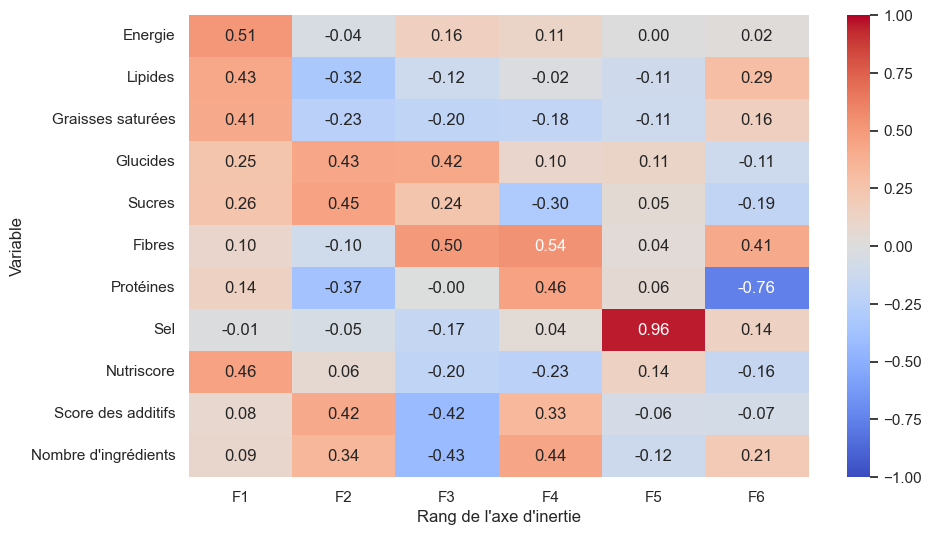

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

ax.set_xlabel("Rang de l'axe d'inertie")
ax.set_ylabel("Variable")
plt.show()

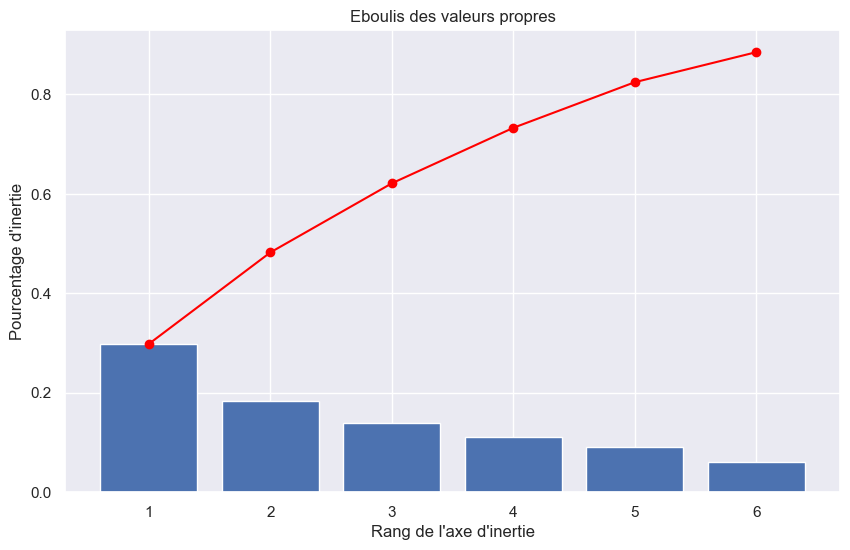

In [88]:
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(),c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

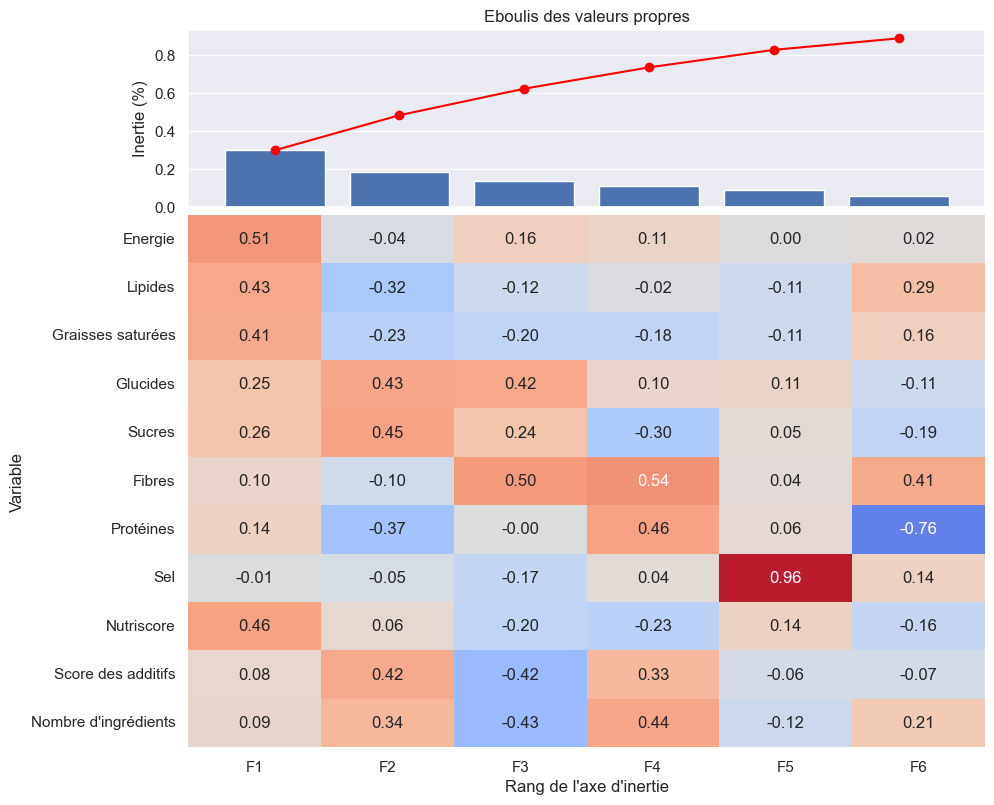

In [89]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7), gridspec_kw={'height_ratios': [1, 3]})
fig.tight_layout(pad=-1.5)

ax = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", cbar=False, fmt="0.2f", ax=axes[1])

ax.set_xlabel("Rang de l'axe d'inertie")
ax.set_ylabel("Variable")

axes[0].bar(range(1, n_components+1), pca.explained_variance_ratio_)
axes[0].plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(),c="red",marker='o')
axes[0].set_ylabel("Inertie (%)")
axes[0].get_xaxis().set_visible(False)
axes[0].set_title("Eboulis des valeurs propres")

plt.show()

In [90]:
x, y = 0,1
#x, y = 2,3

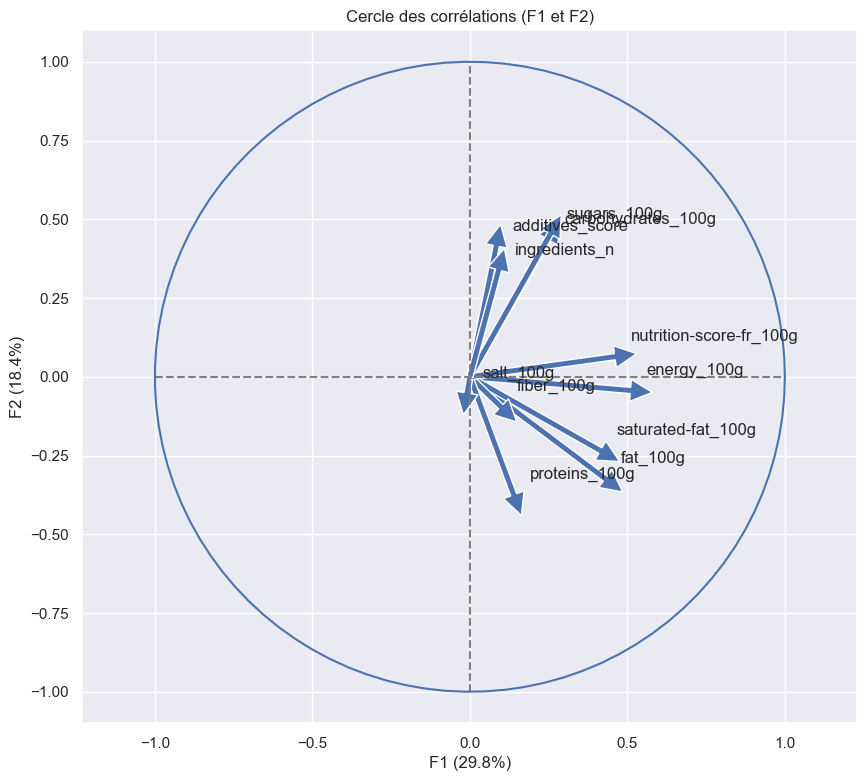

In [91]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[x, i],  #0 for PC1
             pca.components_[y, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[x, i] + 0.05,
             pca.components_[y, i] + 0.05,
             listeColNum[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [92]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                s=10,
                                figsize=[10,8], 
                                marker="."):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, alpha=alpha, s=s)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

In [93]:
X_proj = pca.transform(X_scaled)

In [94]:
x_y = [0, 1]
#x_y = [2, 3]

@interact
def show_articles_more_than(x=widgets.Dropdown(options=listeColFloat, value='fat_100g')):
    
    display_factorial_planes(X_proj, x_y, clusters=dataPCA[x], alpha=0.3, s=4)

interactive(children=(Dropdown(description='x', index=4, options=('additives_n', 'ingredients_from_palm_oil_n'…

In [95]:
listRandom = random.sample(range(len(dataPCA)), 50)

@interact#_manual
def show_articles_more_than(nb=(0,30), resample=False):
    if resample:
        global listRandom
        listRandom = random.sample(range(len(data)), 50)
        
    r = listRandom[:nb]
    tmp = dataPCANoms.iloc[r].values
    display_factorial_planes(X_proj[r], x_y, pca, figsize=(15,11), labels=tmp, marker="o", s=100)

interactive(children=(IntSlider(value=15, description='nb', max=30), Checkbox(value=False, description='resamp…

## ANOVA

In [96]:
Y, x1, x2 = 'nutrition-score-fr_100g', 'additives_n', 'categories' #energy_100g salt_100g nutrition-score-fr_100g
# ingredients_n, additives_score

In [97]:
dataANOVA = data[[Y, x1, x2]].copy()

In [98]:
# Fausses valeurs pour nombre d'additifs
#dataANOVA['additives_n'] = [max(0, int(random.gauss(2, 5))) for _ in range(len(dataANOVA))]

In [99]:
# Fausses valeurs pour nutriscore
#dataANOVA['nutrition-score-fr_100g'] = [max(-14, int(random.gauss(0, 10))) for _ in range(len(dataANOVA))]

In [100]:
# Categorisation

dataANOVA = dataANOVA.dropna()

if Y != 'additives_n' and 'additives_n' in dataANOVA.columns:
    dataANOVA['additives_n'] = pd.qcut(dataANOVA['additives_n'], 6, duplicates='drop')

if Y != 'additives_score' and 'additives_score' in dataANOVA.columns:
    dataANOVA['additives_score'] = pd.qcut(dataANOVA['additives_score'], 6, duplicates='drop')

if Y != 'ingredients_n' and 'ingredients_n' in dataANOVA.columns:
    dataANOVA['ingredients_n'] = pd.qcut(dataANOVA['ingredients_n'], 4, duplicates='drop')

if Y != 'nutrition-score-fr_100g' and 'nutrition-score-fr_100g' in dataANOVA.columns:
    dataANOVA['nutrition-score-fr_100g'] = dataANOVA['nutrition-score-fr_100g'].apply(lambda x : int(x/10)*10)

if 'categories' in dataANOVA.columns:
    dataANOVA = dataANOVA.loc[dataANOVA['categories'].isin(listeCatRemplissage[:10].index)]

if 'nutrition-score-fr_100g' in dataANOVA.columns:
    dataANOVA['nutriscore'] = dataANOVA['nutrition-score-fr_100g']

In [101]:
#dataANOVA = dataANOVA.loc[dataANOVA[Y]>0.1]
#dataANOVA = dataANOVA.loc[dataANOVA[Y]<2]

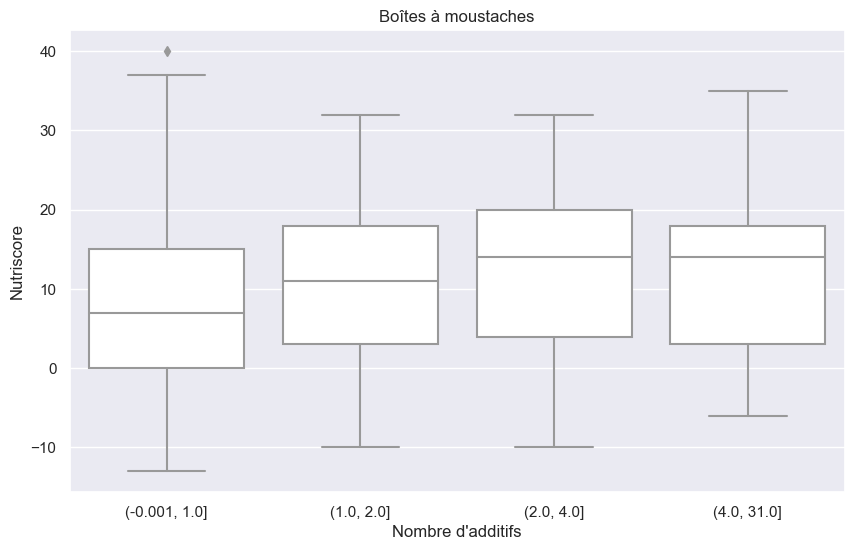

In [102]:
ax = sns.boxplot(x=x1, y=Y, data=dataANOVA, color='white')
plt.xlabel(nomColonnes[x1])
plt.ylabel(nomColonnes[Y])
plt.title('Boîtes à moustaches')
plt.show()

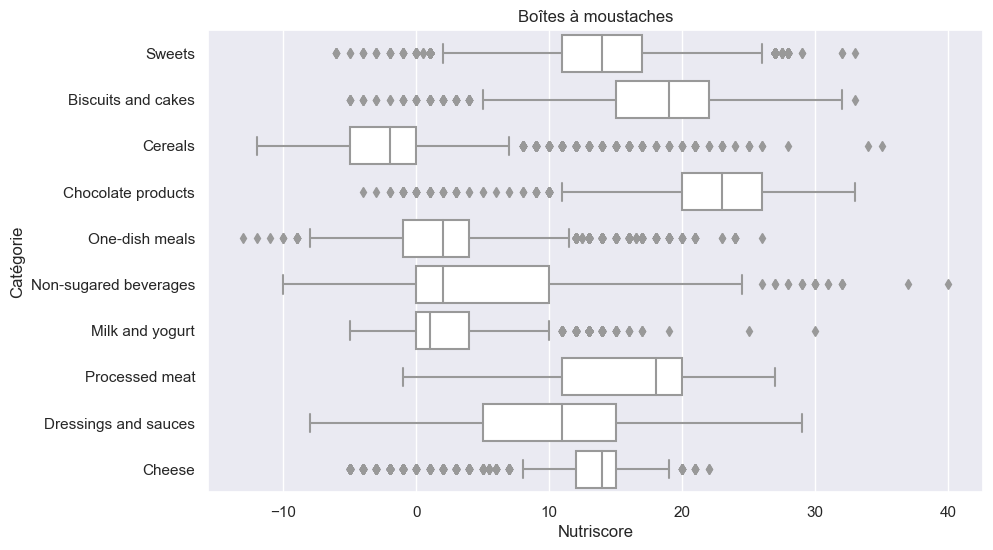

In [103]:
ax = sns.boxplot(x=Y, y=x2, data=dataANOVA, color='white', orient='h')
plt.ylabel(nomColonnes[x2])
plt.xticks(rotation=0)
plt.xlabel(nomColonnes[Y])
plt.title('Boîtes à moustaches')
plt.show()

In [104]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

In [105]:
# Test de Shapiro-Wilk
w, pvalue = stats.shapiro(dataANOVA[Y])
print(w, pvalue)

0.9556175470352173 0.0


C:\Users\Administrateur\.conda\envs\Data\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



In [106]:
tmp = []
for cat in listeCatRemplissage[:6].index:
    tmp.append(dataANOVA.loc[dataANOVA['categories'] == cat, Y].values)

In [107]:
# Test de Bartlett
w, pvalue = stats.bartlett(*tmp)
print(w, pvalue)

468.51539024268493 4.975745522086549e-99


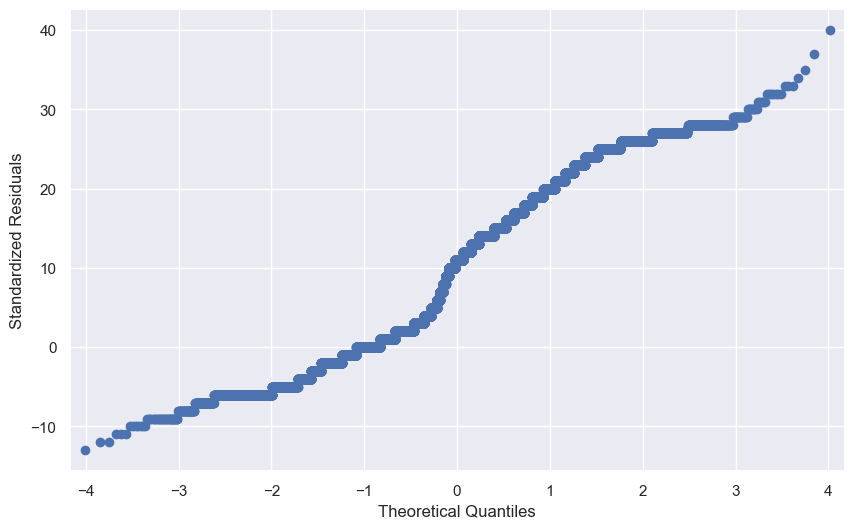

In [108]:
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(dataANOVA[Y])
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()


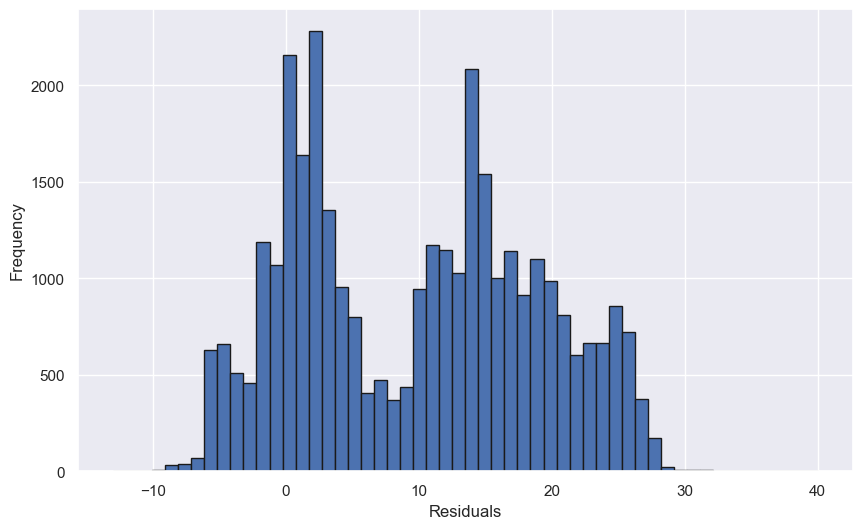

In [109]:
# histogram
plt.hist(dataANOVA[Y], bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()


In [110]:
Ytmp = Y
x1tmp = x1
x2tmp = x2
if Y == 'nutrition-score-fr_100g':
    Ytmp = 'nutriscore'
if x1 == 'nutrition-score-fr_100g':
    x1tmp = 'nutriscore'
if x2 == 'nutrition-score-fr_100g':
    x2tmp = 'nutriscore'

anova_variete_phyto = smf.ols('{}~{}*{}'.format(Ytmp, x1tmp, x2tmp), data=dataANOVA).fit()
#print(anova_variete_phyto.summary())
sm.stats.anova_lm(anova_variete_phyto)

df        sum_sq        mean_sq            F  \
additives_n                 3.0  1.250467e+05   41682.237642  1305.217292   
categories                  9.0  1.621883e+06  180209.183195  5642.982608   
additives_n:categories     27.0  5.931388e+04    2196.810202    68.789845   
Residual                33467.0  1.068772e+06      31.935095          NaN   

                        PR(>F)  
additives_n                0.0  
categories                 0.0  
additives_n:categories     0.0  
Residual                   NaN

In [111]:
pair_t = anova_variete_phyto.t_test_pairwise(x1tmp)
pair_t.result_frame

coef   std err         t         P>|t|  \
(1.0, 2.0]-(-0.001, 1.0]  -0.407077  0.321172 -1.267473  2.049951e-01   
(2.0, 4.0]-(-0.001, 1.0]   0.665280  0.263439  2.525370  1.156222e-02   
(4.0, 31.0]-(-0.001, 1.0] -1.384081  0.264932 -5.224288  1.758724e-07   
(2.0, 4.0]-(1.0, 2.0]      1.072357  0.286279  3.745853  1.800836e-04   
(4.0, 31.0]-(1.0, 2.0]    -0.977004  0.287653 -3.396465  6.834162e-04   
(4.0, 31.0]-(2.0, 4.0]    -2.049361  0.221343 -9.258740  2.187887e-20   

                           Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  \
(1.0, 2.0]-(-0.001, 1.0]        -1.036585         0.222431  2.049951e-01   
(2.0, 4.0]-(-0.001, 1.0]         0.148931         1.181629  2.299076e-02   
(4.0, 31.0]-(-0.001, 1.0]       -1.903357        -0.864805  8.793616e-07   
(2.0, 4.0]-(1.0, 2.0]            0.511241         1.633473  7.201398e-04   
(4.0, 31.0]-(1.0, 2.0]          -1.540815        -0.413194  2.048848e-03   
(4.0, 31.0]-(2.0, 4.0]          -2.483202        -1.615520  1.312732e-19   

                           reject-hs  
(1.0, 2.0]-(-0.001, 1.0]       False  
(2.0, 4.0]-(-0.001, 1.0]        True  
(4.0, 31.0]-(-0.001, 1.0]       True  
(2.0, 4.0]-(1.0, 2.0]           True  
(4.0, 31.0]-(1.0, 2.0]          True  
(4.0, 31.0]-(2.0, 4.0]          True

In [112]:
pair_t = anova_variete_phyto.t_test_pairwise(x2)
pair_t.result_frame

coef   std err           t  \
Cereals-Biscuits and cakes                 -20.106798  0.235642  -85.327807   
Cheese-Biscuits and cakes                   -6.067723  0.238108  -25.483107   
Chocolate products-Biscuits and cakes        3.301883  0.248143   13.306385   
Dressings and sauces-Biscuits and cakes    -10.572772  0.255164  -41.435143   
Milk and yogurt-Biscuits and cakes         -16.113354  0.250940  -64.211921   
Non-sugared beverages-Biscuits and cakes   -14.344986  0.241056  -59.508976   
One-dish meals-Biscuits and cakes          -16.686977  0.242164  -68.907860   
Processed meat-Biscuits and cakes           -1.965358  0.291494   -6.742356   
Sweets-Biscuits and cakes                   -3.333310  0.248043  -13.438450   
Cheese-Cereals                              14.039075  0.147059   95.465703   
Chocolate products-Cereals                  23.408680  0.162806  143.782493   
Dressings and sauces-Cereals                 9.534025  0.173320   55.008150   
Milk and yogurt-Cereals                      3.993444  0.167039   23.907249   
Non-sugared beverages-Cereals                5.761812  0.151786   37.960131   
One-dish meals-Cereals                       3.419821  0.153539   22.273287   
Processed meat-Cereals                      18.141439  0.223383   81.212257   
Sweets-Cereals                              16.773488  0.162654  103.123915   
Chocolate products-Cheese                    9.369605  0.166355   56.322885   
Dressings and sauces-Cheese                 -4.505050  0.176658  -25.501510   
Milk and yogurt-Cheese                     -10.045631  0.170500  -58.918666   
Non-sugared beverages-Cheese                -8.277263  0.155586  -53.200395   
One-dish meals-Cheese                      -10.619254  0.157297  -67.510689   
Processed meat-Cheese                        4.102365  0.225983   18.153446   
Sweets-Cheese                                2.734413  0.166206   16.451954   
Dressings and sauces-Chocolate products    -13.874655  0.189968  -73.036985   
Milk and yogurt-Chocolate products         -19.415236  0.184255 -105.371725   
Non-sugared beverages-Chocolate products   -17.646868  0.170548 -103.471400   
One-dish meals-Chocolate products          -19.988859  0.172110 -116.139695   
Processed meat-Chocolate products           -5.267241  0.236533  -22.268550   
Sweets-Chocolate products                   -6.635192  0.180289  -36.803165   
Milk and yogurt-Dressings and sauces        -5.540581  0.193607  -28.617605   
Non-sugared beverages-Dressings and sauces  -3.772213  0.180612  -20.885707   
One-dish meals-Dressings and sauces         -6.114204  0.182088  -33.578280   
Processed meat-Dressings and sauces          8.607414  0.243889   35.292362   
Sweets-Dressings and sauces                  7.239463  0.189837   38.135180   
Non-sugared beverages-Milk and yogurt        1.768368  0.174594   10.128488   
One-dish meals-Milk and yogurt              -0.573623  0.176120   -3.257003   
Processed meat-Milk and yogurt              14.147996  0.239466   59.081463   
Sweets-Milk and yogurt                      12.780044  0.184120   69.411496   
One-dish meals-Non-sugared beverages        -2.341991  0.161725  -14.481279   
Processed meat-Non-sugared beverages        12.379627  0.229087   54.038989   
Sweets-Non-sugared beverages                11.011676  0.170403   64.621479   
Processed meat-One-dish meals               14.721618  0.230252   63.936891   
Sweets-One-dish meals                       13.353667  0.171966   77.652832   
Sweets-Processed meat                       -1.367951  0.236428   -5.785915   

                                                    P>|t|  Conf. Int. Low  \
Cereals-Biscuits and cakes                   0.000000e+00      -20.568664   
Cheese-Biscuits and cakes                   6.868652e-142       -6.534422   
Chocolate products-Biscuits and cakes        2.690852e-40        2.815514   
Dressings and sauces-Biscuits and cakes      0.000000e+00      -11.072904   
Milk and yogurt-Biscuits and 

In [113]:
import pingouin as pg

In [114]:
pg.homoscedasticity(data=dataANOVA, dv=Y, group=x1)

W          pval  equal_var
levene  117.916619  5.782844e-76      False

In [115]:
pg.pairwise_gameshowell(data=dataANOVA, dv=Y, between=x1)

A            B    mean(A)    mean(B)      diff        se  \
0  (-0.001, 1.0]   (1.0, 2.0]   8.205425  11.242582 -3.037158  0.149500   
1  (-0.001, 1.0]   (2.0, 4.0]   8.205425  12.747430 -4.542005  0.141106   
2  (-0.001, 1.0]  (4.0, 31.0]   8.205425  12.011167 -3.805742  0.140872   
3     (1.0, 2.0]   (2.0, 4.0]  11.242582  12.747430 -1.504847  0.182746   
4     (1.0, 2.0]  (4.0, 31.0]  11.242582  12.011167 -0.768585  0.182565   
5     (2.0, 4.0]  (4.0, 31.0]  12.747430  12.011167  0.736263  0.175757   

           T           df          pval    hedges  
0 -20.315462  6468.929035  1.557976e-12 -0.329183  
1 -32.188667  8195.244953  1.176725e-12 -0.491583  
2 -27.015682  7427.364592  6.177503e-12 -0.415182  
3  -8.234652  9023.645487  0.000000e+00 -0.171462  
4  -4.209923  8662.260586  1.514438e-04 -0.090050  
5   4.189089  9599.997251  1.657290e-04  0.085271

In [116]:
pg.welch_anova(data=dataANOVA, dv=Y, between=x1)

Source  ddof1         ddof2           F          p-unc       np2
0  additives_n      3  10343.394229  520.268169  6.354159e-315  0.043494

In [117]:
pg.anova(data=dataANOVA, dv=Y, between=x1)

Source  ddof1  ddof2           F          p-unc       np2
0  additives_n      3  33503  507.816759  9.387247e-323  0.043494

In [118]:
pg.welch_anova(data=dataANOVA, dv=Y, between=x2)

Source  ddof1         ddof2           F  p-unc       np2
0  categories      9  13033.725403  6484.53845    0.0  0.604502

In [119]:
pg.anova(data=dataANOVA, dv=Y, between=x2)

Source  ddof1  ddof2            F  p-unc       np2
0  categories      9  33497  5688.744052    0.0  0.604502